# Analysis 1.0 

## Import packages

In [2]:
#general
import pandas as pd 
from matplotlib import pyplot as plt
import json
import numpy as np
import warnings
import pickle
from pprint import pprint
from datetime import date
import tqdm

#for OpenAlex
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from itertools import chain

#for Gender Guesser
from urllib.request import urlopen
from genderize import Genderize
import gender_guesser.detector as gender
import pycountry
import re

#for Geopandas
import mapclassify
import geopandas as gpd

#for topic model
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.porter import *

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import scipy.interpolate.interpnd
import pyLDAvis
import pyLDAvis.gensim

## Import data

In [3]:
%%time
with open('Data backup/16112023authordata.pkl', 'rb') as f:
    author_data = pickle.load(f)

CPU times: user 1.22 s, sys: 755 ms, total: 1.98 s
Wall time: 3.91 s


In [4]:
%%time
with open('Data backup/08112023articledata.pkl', 'rb') as f:
    article_data = pickle.load(f)

CPU times: user 1.47 s, sys: 2.16 s, total: 3.63 s
Wall time: 13.9 s


## Clean data

In [5]:
#author data should be duplicated due to some papers having several authors
print(len(author_data))
print(author_data.article_id.nunique())
print(len(author_data.drop_duplicates(subset=['article_id'])))

2000305
518351
518351


In [6]:
#article data should not be duplicated. 
print(len(article_data))
print(article_data.article_id.nunique())
print(len(article_data.drop_duplicates(subset=['article_id'])))

527193
527169
527169


In [7]:
#Clean article data for duplicates 
article_data=article_data.drop_duplicates(subset=['article_id'])
print(len(article_data))

527169


In [8]:
#merge article and author data into one dataframe

In [9]:
print(len(article_data)) #the article data can be longer due to missing author data info - we should remove this from article data
print(author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(author_data[author_data['author_position']=='first'])) #this is longer - so we must have duplicates here

527169
518351
518375


In [10]:
#find duplicates 
first_author_data=author_data[author_data['author_position']=='first']
first_author_article_id=first_author_data['article_id']
unique_article_id=pd.Series(author_data['article_id'].unique())

In [11]:
len(first_author_article_id)-len(unique_article_id)

24

In [12]:
# Find IDs that are in series1 but not in series2
diff_ids_first_author = first_author_article_id[~first_author_article_id.isin(unique_article_id)]

# Find IDs that are in series2 but not in series1
diff_ids_unique = unique_article_id[~unique_article_id.isin(first_author_article_id)]

# Combine both sets of differing IDs
all_diff_ids = pd.concat([diff_ids_first_author, diff_ids_unique])

print("IDs in series1 but not in series2:")
print(diff_ids_first_author)

print("\nIDs in series2 but not in series1:")
print(diff_ids_unique)

print("\nAll differing IDs:")
print(all_diff_ids)

IDs in series1 but not in series2:
Series([], Name: article_id, dtype: object)

IDs in series2 but not in series1:
Series([], dtype: object)

All differing IDs:
Series([], dtype: object)


In [13]:
# Find and print the duplicate IDs
duplicate_ids = first_author_article_id[first_author_article_id.duplicated()]
print("Duplicate IDs:", duplicate_ids)


Duplicate IDs: 55500      https://openalex.org/W4234339056
290594     https://openalex.org/W2035314140
338162     https://openalex.org/W3125556312
338163     https://openalex.org/W2316535545
338164     https://openalex.org/W2111441948
585111     https://openalex.org/W2036660639
1577025    https://openalex.org/W3204437910
1577030    https://openalex.org/W3216943153
1577034    https://openalex.org/W3098437163
1577042    https://openalex.org/W3135460778
1577043    https://openalex.org/W3131052732
1577045    https://openalex.org/W3134611429
1577052    https://openalex.org/W3094179919
1577055    https://openalex.org/W3146527195
1577061    https://openalex.org/W3155447072
1577065    https://openalex.org/W3134883889
1577070    https://openalex.org/W3160022076
1577076    https://openalex.org/W3171124799
1577079    https://openalex.org/W3165130521
1577081    https://openalex.org/W3168675126
1577084    https://openalex.org/W3156339046
1577094    https://openalex.org/W3180244721
1577099    https:

In [14]:
duplicate_author_data=first_author_data[first_author_data['article_id'].isin(duplicate_ids.to_list())]
duplicate_author_data = duplicate_author_data.sort_values(by='article_id')
duplicate_author_data

,author_position,author_countries,is_corresponding,raw_affiliation_string,raw_author_name,author.display_name,author.id,institution_country_code,institution_name,institution_id,institution_type,article_id,selected_full_name,extracted_first_name,country_name,author_country_name,author_country_name_api,predicted_gender
290541,first,CH,True,"Centre de Recherches en Physique des Plasmas, ...",R. A. Pitts,R.A. Pitts,https://openalex.org/A5043388540,CH,École Polytechnique Fédérale de Lausanne,https://openalex.org/I5124864,education,https://openalex.org/W2035314140,r. a. pitts,r,switzerland,switzerland,swiss,unknown
290594,first,CH,True,"Centre de Recherches en Physique des Plasmas, ...",R. A. Pitts,R.A. Pitts,https://openalex.org/A5043388540,CH,École Polytechnique Fédérale de Lausanne,https://openalex.org/I5124864,education,https://openalex.org/W2035314140,r. a. pitts,r,switzerland,switzerland,swiss,unknown
2730,first,US,True,S. Outcalt is an assistant professor of geogra...,S. I. Outcalt,Samuel I. Outcalt,https://openalex.org/A5059700508,US,University of Michigan–Ann Arbor,https://openalex.org/I27837315,education,https://openalex.org/W2036660639,samuel i. outcalt,samuel,united states,united states,usa,male
585111,first,US,True,S. Outcalt is an assistant professor of geogra...,S. I. Outcalt,Samuel I. Outcalt,https://openalex.org/A5059700508,US,University of Michigan–Ann Arbor,https://openalex.org/I27837315,education,https://openalex.org/W2036660639,samuel i. outcalt,samuel,united states,united states,usa,male
338160,first,unknown,False,,Vincent DeAngelis,Vincent DeAngelis,https://openalex.org/A5074446304,unknown,unknown,unknown,unknown,https://openalex.org/W2111441948,vincent deangelis,vincent,other_countries,other_countries,other_countries,andy
338164,first,unknown,False,,Vincent DeAngelis,Vincent DeAngelis,https://openalex.org/A5074446304,unknown,unknown,unknown,unknown,https://openalex.org/W2111441948,vincent deangelis,vincent,other_countries,other_countries,other_countries,andy
338159,first,unknown,True,,Eduard Kruglyakov,Eduard P. Kruglyakov,https://openalex.org/A5040638151,unknown,unknown,unknown,unknown,https://openalex.org/W2316535545,eduard p. kruglyakov,eduard,other_countries,other_countries,other_countries,andy
338163,first,unknown,True,,Eduard Kruglyakov,Eduard P. Kruglyakov,https://openalex.org/A5040638151,unknown,unknown,unknown,unknown,https://openalex.org/W2316535545,eduard p. kruglyakov,eduard,other_countries,other_countries,other_countries,andy
1577052,first,BR,True,"Federal Institute of Rio de Janeiro, Antônio B...",Eduardo Dessupoio Moreira Dias,Eduardo Dessupoio Moreira Dias,https://openalex.org/A5019005687,BR,"Rio de Janeiro Federal Institute of Education,...",https://openalex.org/I270441400,government,https://openalex.org/W3094179919,eduardo dessupoio moreira dias,eduardo,brazil,brazil,other_countries,andy
1576970,first,BR,True,"Federal Institute of Rio de Janeiro, Antônio B...",Eduardo Dessupoio Moreira Dias,Eduardo Dessupoio Moreira Dias,https://openalex.org/A5019005687,BR,"Rio de Janeiro Federal Institute of Education,...",https://openalex.org/I270441400,government,https://openalex.org/W3094179919,eduardo dessupoio moreira dias,eduardo,brazil,brazil,other_countries,andy


In [15]:
#now that we have checked the duplicates we want to remove them from the author data
# Remove duplicates and print the updated Series
drop_duplicate_author_data=duplicate_author_data.drop_duplicates(subset=['article_id'], keep='last')
print(len(duplicate_author_data))
print(len(drop_duplicate_author_data))


48
24


In [16]:
#check that first author data and unique IDs are now same length
first_author_data=first_author_data.drop_duplicates(subset=['article_id'], keep='first')
print(len(first_author_data))
print(len(unique_article_id))

518351
518351


In [17]:
#finally let's make sure to drop the same index in the overall author dataset 
indices_to_remove = drop_duplicate_author_data.index.to_list()

# Remove entries based on index
author_data = author_data.drop(indices_to_remove)

In [18]:
print(len(article_data)) #the article data can be longer due to missing author data info - we should remove this from article data
print(author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(author_data[author_data['author_position']=='first'])) #it matches! 

527169
518351
518351


In [19]:
#finally lets merge author data and article data
article_author_data=pd.merge(article_data, author_data, on='article_id')

In [20]:
#check that it works 
print(len(article_author_data)) #we have multiply authors per article so this should be longer
print(article_author_data.article_id.nunique()) #auhtor data article ids should match article ids per first positon
print(len(article_author_data[article_author_data['author_position']=='first'])) #it works! 

2000281
518351
518351


In [21]:
first_author_article_data=article_author_data[article_author_data['author_position']=='first']

After making sure our data does not contain duplicates we end up with 5 dataframes to work with overall 
- article_data. Containing only info on our articles represented by our author
- author_data. Containing only info on our authors. 
- article_author_data. The two merged containing info on both articles and authors
- first_author_data. Containing only info on first author 
- first_author_article_data. Containing both article and author info on first author

However, since article_author_data and first_author_article_data contains all info we will primeraly use these 

## Plotting

In [323]:
#plotting parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:pink', 'tab:red', 'tab:purple', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:olive', 'tab:orange', 'tab:brown', 'tab:gray']) 
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "serif"


font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [324]:
def cat_plot(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=font, rot=0, xmargins=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalise data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): font type. If chinese letters then use: 'Heiti TC'. Default is font. 
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()    
    count=value_counts.iloc[:,1]
    cats=value_counts.iloc[:,0]
    
    fig, ax = plt.subplots()
    ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')
    plt.xticks(cats, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_path=f'Plots/{date.today()}/{data.name}'
    plt.savefig(save_path)
    
    plt.show()



In [325]:
def cat10_plot(data, title=None, xlabel=None, ylabel='Frequency', norm=False, multiply=1, font=font, rot=0, xmargins=None):
    """
    Create a categorical plot for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - norm(True/False): Whether to normalise data or not. Default is False.
    - multiply(int): Multiply data to achieve percentage. This should be 100 if norm=True. Default is 1.
    - rot(int): Rotation scale of x-tick-labels. Default is 0.
    - font(str): font type. If chinese letters then use: 'Heiti TC'. Default is font. 
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    value_counts = data.value_counts(normalize=norm).mul(multiply).reset_index()[0:10]    
    count=value_counts.iloc[:,1]
    cats=value_counts.iloc[:,0]
    
    fig, ax = plt.subplots()
    ax.bar(cats, count, width=0.8, alpha=0.6, edgecolor='white', label='Histogram of Data')
    plt.xticks(cats, font=font, size=10, rotation=rot)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    save_path=f'Plots/{date.today()}/{data.name}'
    plt.savefig(save_path)
    
    plt.show()



In [326]:
def hist_plot(data, log=False, title=None, xlabel=None, ylabel='Frequency', xmargins=None):
    """
    Create a histogram for a given DataFrame column.

    Parameters:
    - data (pd.DataFrame): The input DataFrame column.
    - log (True/False): Plot on log scale. Default is False.
    - xlabel (str): The label for the x-axis. Default is None.
    - xmargins (int): The size of the x-margins. Default is None.

    Returns:
    - None
    """
    
    fig, ax = plt.subplots()
    
    counts, bin_edges, _ = ax.hist(data, log=log, alpha=0.6, edgecolor='white', label='Histogram of Data')
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binwidth = bin_edges[1] - bin_edges[0]

    # Poisson errors on the count in each bin
    s_counts = np.sqrt(counts)
    
    # We remove any bins, which don't have any counts in them:
    x = bin_centers[counts>0]
    y = counts[counts>0]
    sy = s_counts[counts>0]

    # Plot data with error
    ax.errorbar(x, y, yerr=sy, fmt='.k', ecolor='k', elinewidth=1, capsize=1, capthick=1, label='Counts with Poisson Errors')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.margins(x=xmargins)
    
    ax.legend()

    save_path=f'Plots/{date.today()}/{data.name}'
    plt.savefig(save_path)
    
    plt.show()

In [327]:

def stacked_bar_plot_normalized(dataframe, x_col, y_cols, title=None, xlabel=None, ylabel=None):
    """
    Generate a stacked bar plot for normalized gender distribution over years.

    Parameters:
    - dataframe: DataFrame containing the data.
    - year_col: Column name for the years.
    - gender_cols: List of column names representing different gender categories.
    - title: Title of the plot. Default is None.
    - xlabel: Label for the x-axis. Default is None.
    - ylabel: Label for the y-axis. Default is None.
    """

    # Calculate the total count per year
    total_counts = dataframe[y_cols].sum(axis=1)

    # Normalize the data to percentages
    normalized_df = dataframe.copy()
    for y_col in y_cols:
        normalized_df[y_col] = (normalized_df[y_col] / total_counts) * 100

    # Initialize the bottom values for stacking
    bottom_values = [0] * len(normalized_df)

    for i, y_col in enumerate(y_cols):
        plt.bar(normalized_df[x_col], normalized_df[y_col], bottom=bottom_values, label=y_col)
        bottom_values = [bottom + value for bottom, value in zip(bottom_values, normalized_df[y_col])]

    # Adding labels and title
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()

    save_path=f'Plots/{date.today()}/{[name for name, obj in globals().items() if obj is author_data][0]}'
    plt.savefig(save_path)

    # Display the plot
    plt.show()

In [328]:
def plt_plot(x, y, title=None, xlabel=None, ylabel=None, label=None, font='font', xmargins=None, new_figure=True):
    """
    Create a plot between two variables for two given lists of numbers.

    Parameters:
    - x (list): The input x data.
    - y (list): The input y data.
    - title (str): The title of the plot. Default is None.
    - xlabel (str): The label for the x-axis. Default is None.
    - ylabel(str): The label for the y-axis. Default is Frequncy.
    - font(str): font type. If Chinese letters then use: 'Heiti TC'. Default is 'font'.
    - xmargins (float): The margins for the x-axis. Default is None.
    - new_figure (bool): Whether to create a new figure or plot in the same figure. Default is True.

    Returns:
    - None
    """
    if new_figure:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.gcf(), plt.gca()

    ax.plot(x, y, label=label)
    plt.margins(x=xmargins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    save_path = f'Plots/{date.today()}/{[name for name, obj in globals().items() if obj is x][0]}{[name for name, obj in globals().items() if obj is y][0]}'
    plt.savefig(save_path)

    plt.show()


### Plot author data

In [806]:
author_data.columns

Index(['author_position', 'author_countries', 'is_corresponding',
       'raw_affiliation_string', 'raw_author_name', 'author.display_name',
       'author.id', 'institution_country_code', 'institution_name',
       'institution_id', 'institution_type', 'article_id',
       'selected_full_name', 'extracted_first_name', 'country_name',
       'author_country_name', 'author_country_name_api', 'predicted_gender'],
      dtype='object')

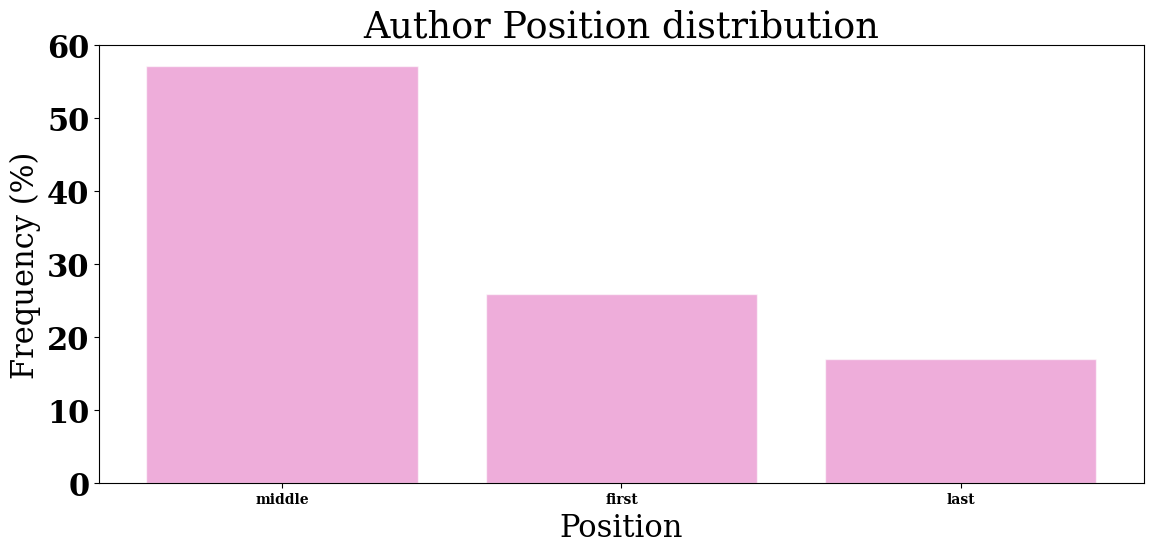

In [1136]:
cat_plot(article_author_data.author_position, title='Author Position distribution', xlabel='Position', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None)


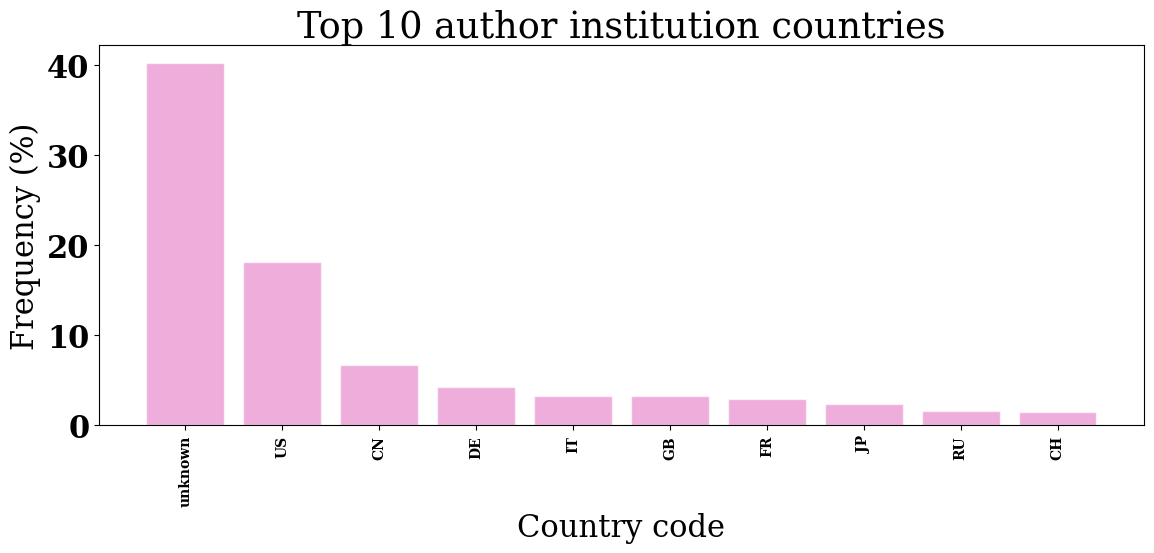

In [1139]:
cat10_plot(article_author_data.institution_country_code, title='Top 10 author institution countries', xlabel='Country code', ylabel='Frequency (%)', norm=True, multiply=100, rot=90, xmargins=None)


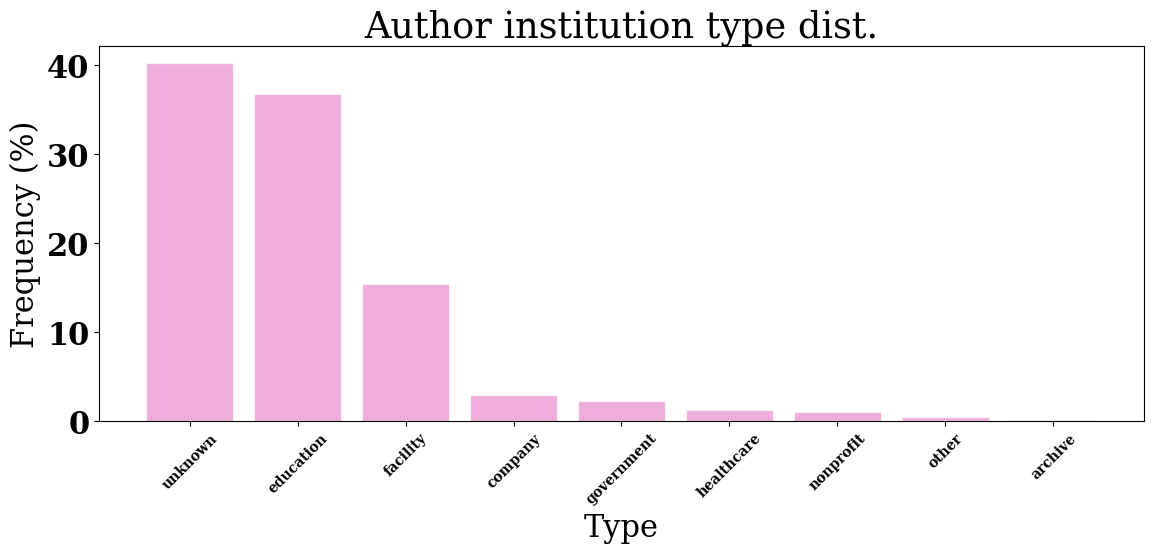

In [1140]:
cat_plot(article_author_data.institution_type, title='Author institution type dist.', xlabel='Type', ylabel='Frequency (%)', norm=True, multiply=100, rot=45, xmargins=None)


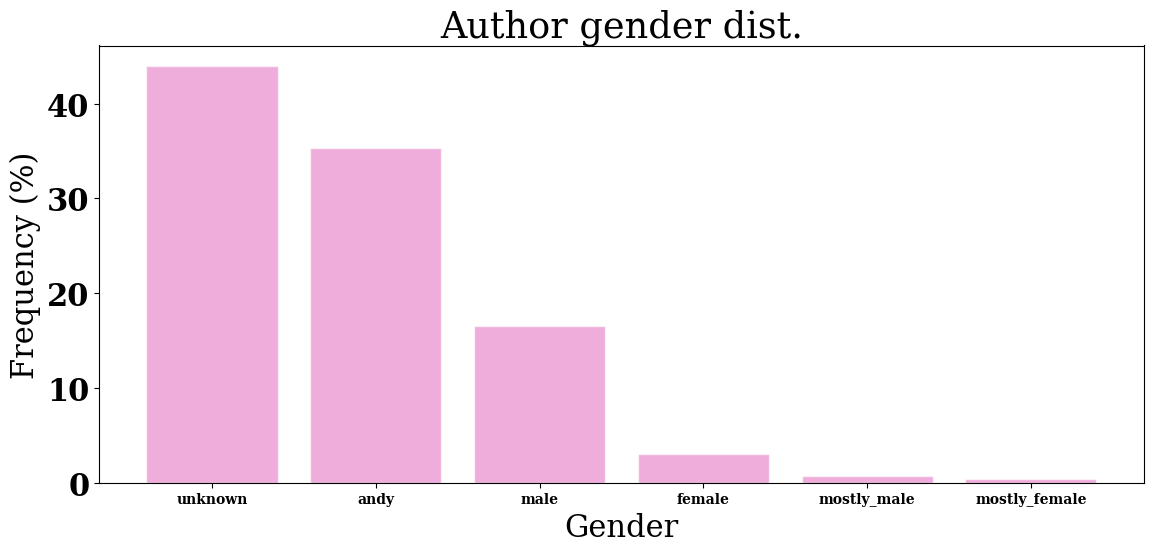

In [1141]:
cat_plot(article_author_data.predicted_gender, title='Author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, xmargins=None)


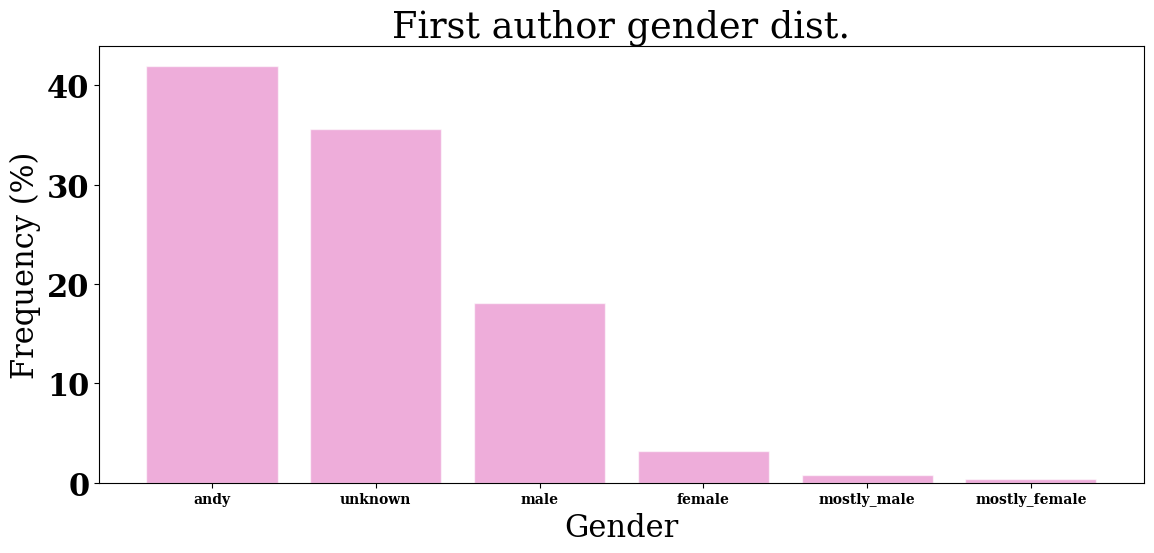

In [1142]:
cat_plot(first_author_article_data.predicted_gender, title='First author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, xmargins=None)


In [ ]:
## WORLD MAP PLOTTING 

In [1151]:
#create dataframe with country
df_country=article_author_data.author_countries.reset_index()
#select only one country per author
df_country['author_first_country'] = df_country['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)
#calc percentage of country appearing
df_country=df_country.author_first_country.value_counts(normalize=True).mul(100).reset_index()

In [1152]:
# generate country code for map plotting 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(alpha_2=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
df_country['map_code']=alpha3code(df_country.author_first_country)


In [1153]:
#import world dataset
world = gpd.read_file('ne_110m_admin_0_countries.shx')


In [1154]:
world = world[['ADMIN', 'ISO_A3', 'GU_A3', 'CONTINENT',  'geometry']] 
world.columns=['map_name', 'map_code', 'GU_A3', 'continent',  'geometry']


In [1155]:
world['map_code'][world['map_code']=='-99']=world['GU_A3']

In [1156]:
missing_country=df_country[~df_country['map_code'].isin(world['map_code'])]

In [1157]:
len(missing_country)

841

In [1158]:
#we are missing some countries on the map but will not prioritise getting them right now - maybe later 
missing_country=author_data[['author_countries','country_name']][author_data['author_countries'].isin([missing_country['author_first_country'].to_list()[i] for i in range(len(missing_country))])].value_counts().reset_index()

In [1159]:
world=world.drop(columns=['GU_A3'])

In [1160]:
# then merge with our data 
merge_map=pd.merge(world,df_country,on='map_code')

In [1161]:
#we are missing some 
len(merge_map)

163

In [1162]:
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
location=location.rename(columns={"name": "map_name"})


In [1163]:
new_country_data = {
    'map_name': ['France', 'Norway', 'North Macedonia', 'New Caledonia', 'Myanmar', 'Puerto Rico', 'Lesotho'],
    'latitude': [46.603354, 60.472024, 41.6086, -20.904305, 21.9162, 18.2208, -29.609988],
    'longitude': [1.888334, 8.468946, 21.7453, 165.618042, 95.9560, -66.5901, 28.233608]
}

# Create a new DataFrame with the rows to add
new_rows_df = pd.DataFrame(new_country_data)

location = pd.concat([location, new_rows_df], ignore_index=True)

# Display the updated DataFrame
location

,map_name,latitude,longitude
0,Afghanistan,33.939110,67.709953
1,Albania,41.153332,20.168331
2,Algeria,28.033886,1.659626
3,Angola,-11.202692,17.873887
4,Argentina,-38.416097,-63.616672
...,...,...,...
160,North Macedonia,41.608600,21.745300
161,New Caledonia,-20.904305,165.618042
162,Myanmar,21.916200,95.956000
163,Puerto Rico,18.220800,-66.590100


In [1164]:
merge_map=merge_map.merge(location,on='map_name').sort_values(by='proportion',ascending=False).reset_index()

In [1165]:
mergeworld = pd.merge(merge_map, world, how="outer")


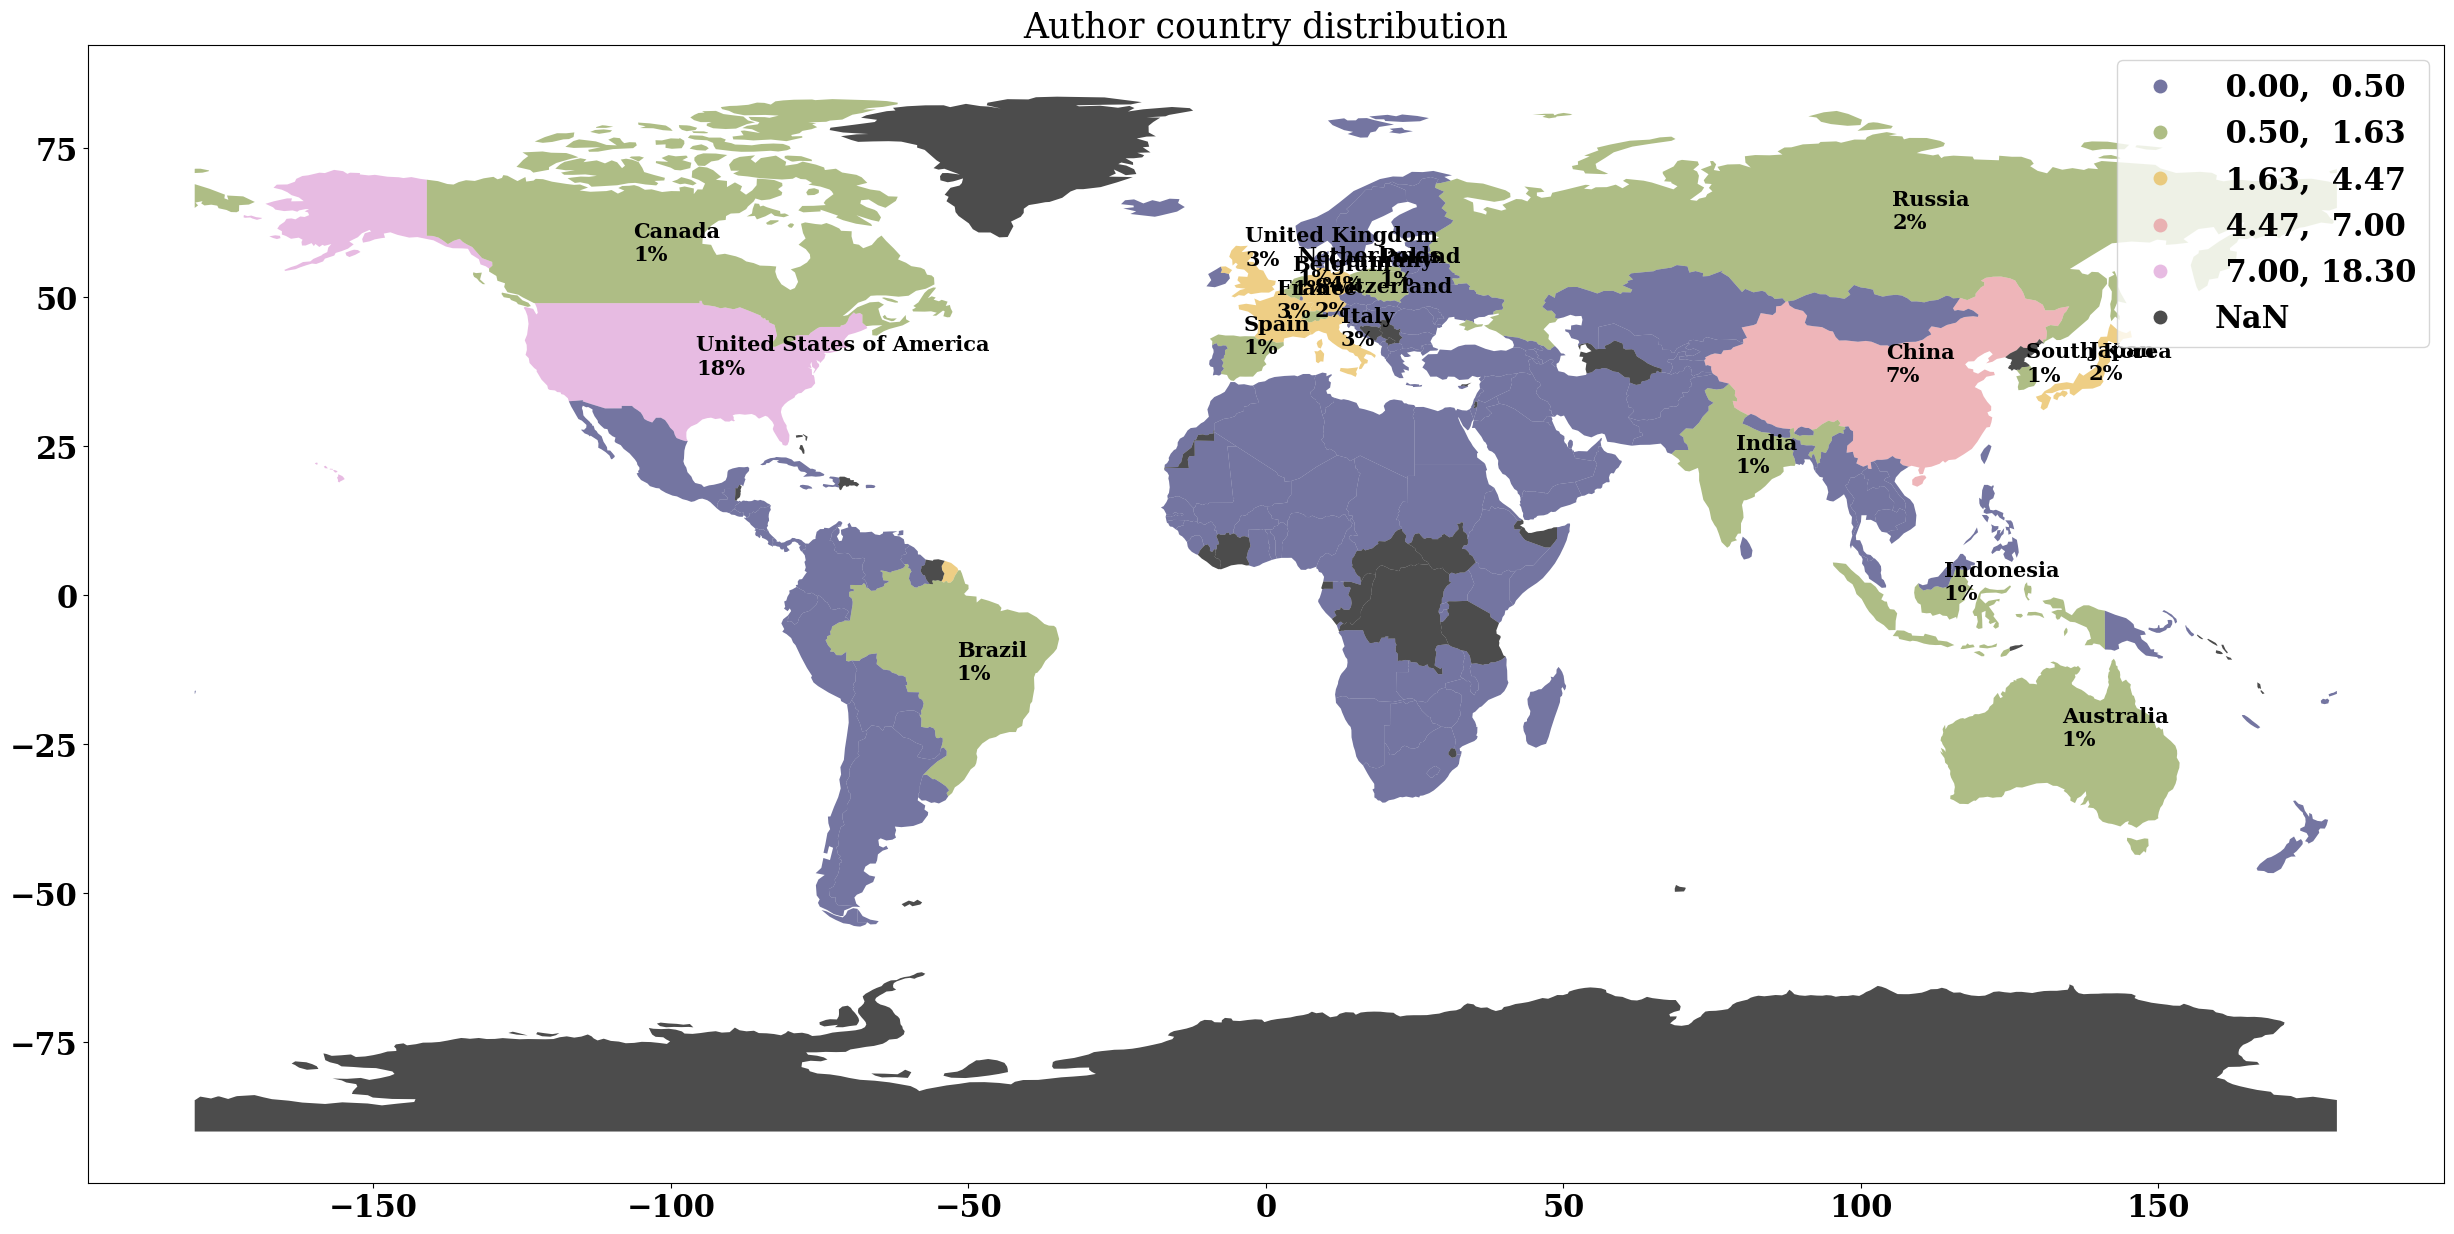

In [1168]:
fig_world=mergeworld.plot(column='proportion',
                scheme='natural_breaks',
                cmap='tab20b', 
                alpha=0.7,
                figsize=(25, 20),
                missing_kwds={'color': 'k', 'alpha':0.7}, 
                legend=True);

plt.title('Author country distribution',fontsize=25)
# add countries names and numbers for top 10 appearing countries 
for i in range(len(mergeworld[mergeworld['proportion']>0.5])):
    plt.text(float(mergeworld.longitude[i]),float(mergeworld.latitude[i]),"{}\n{}".format(mergeworld.map_name[i],f'{round(mergeworld.proportion[i])}%'),size=15)
#plt.savefig('Plots/22102023/authorcountrymap.png')
plt.show()


### Plot article data

In [1169]:
article_data.columns

Index(['article_id', 'doi', 'publication_year', 'publication_date', 'title',
       'cited_by_count', 'grants', 'abstract', 'journal_id', 'journal_name',
       'total_author_counts'],
      dtype='object')

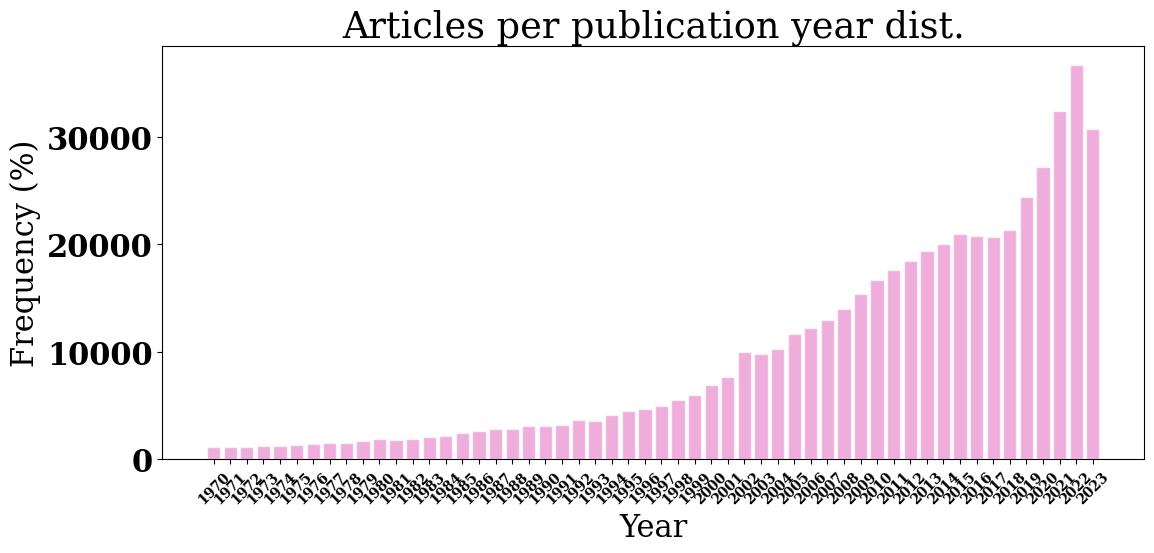

In [1170]:
cat_plot(first_author_article_data.publication_year, title='Articles per publication year dist.', xlabel='Year', ylabel='Frequency (%)', norm=False, multiply=1, rot=45, xmargins=None)


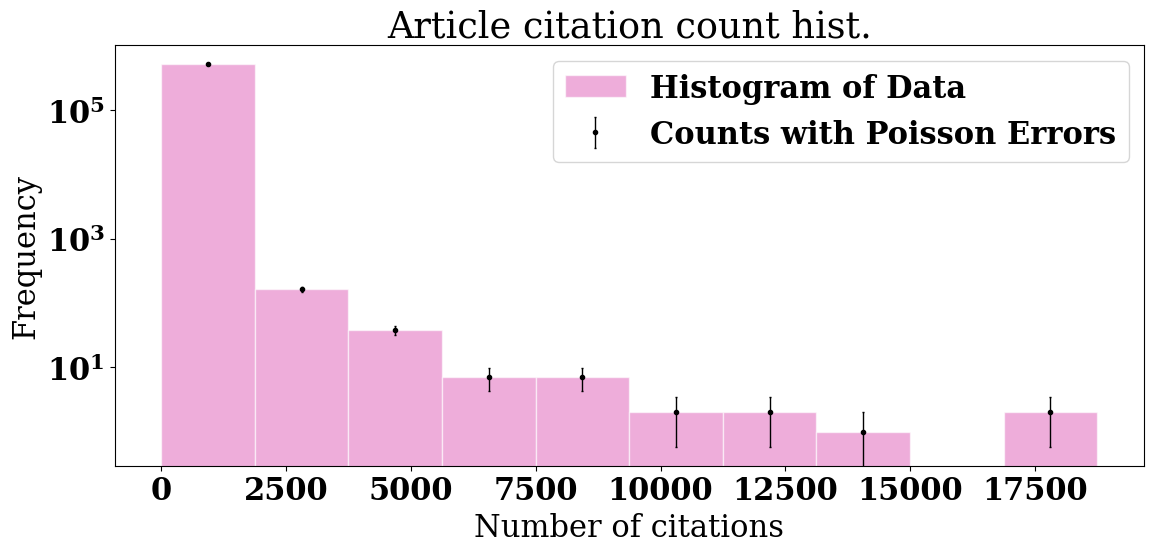

In [1171]:
hist_plot(first_author_article_data.cited_by_count, log=True, title='Article citation count hist.', xlabel='Number of citations', ylabel='Frequency log', xmargins=None)


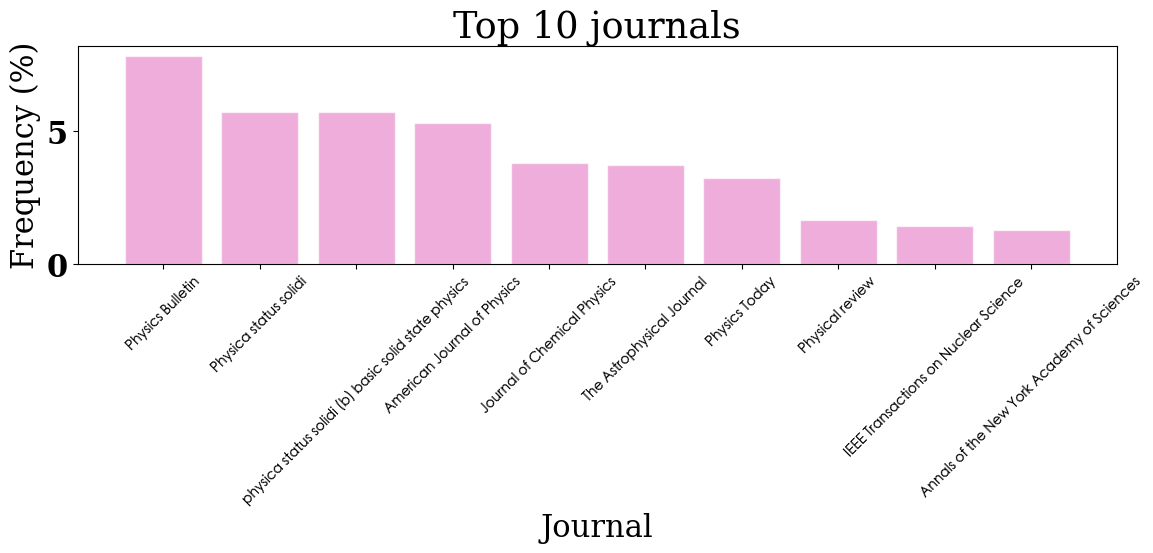

In [1172]:
cat10_plot(first_author_article_data.journal_name, title='Top 10 journals', xlabel='Journal', ylabel='Frequency (%)', norm=True, multiply=100, font='Heiti TC', rot=45, xmargins=None)


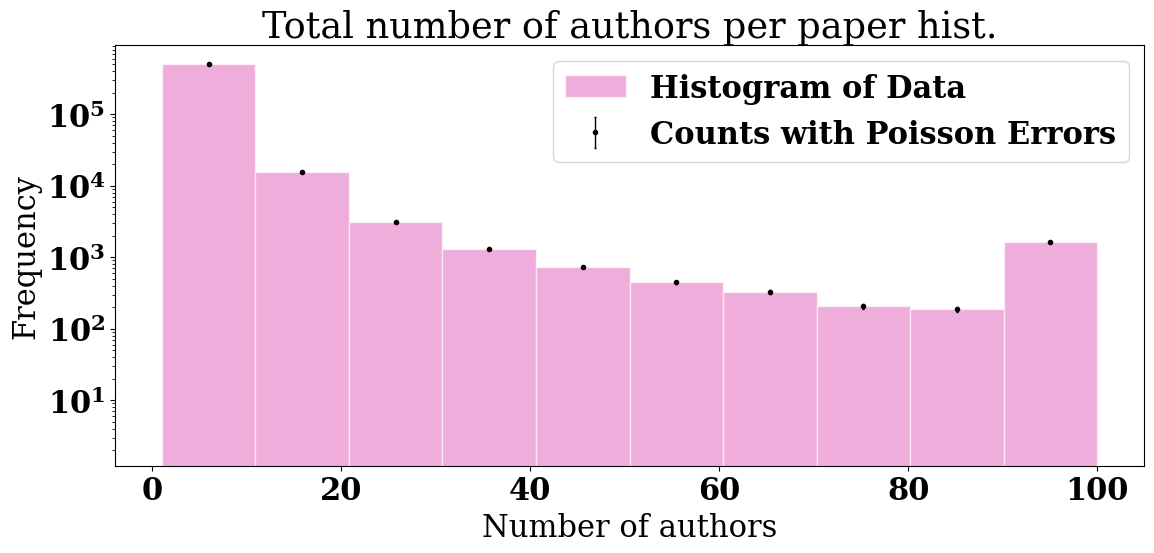

In [1173]:
hist_plot(first_author_article_data.total_author_counts, log=True, title='Total number of authors per paper hist.', xlabel='Number of authors', ylabel='Frequency log', xmargins=None)

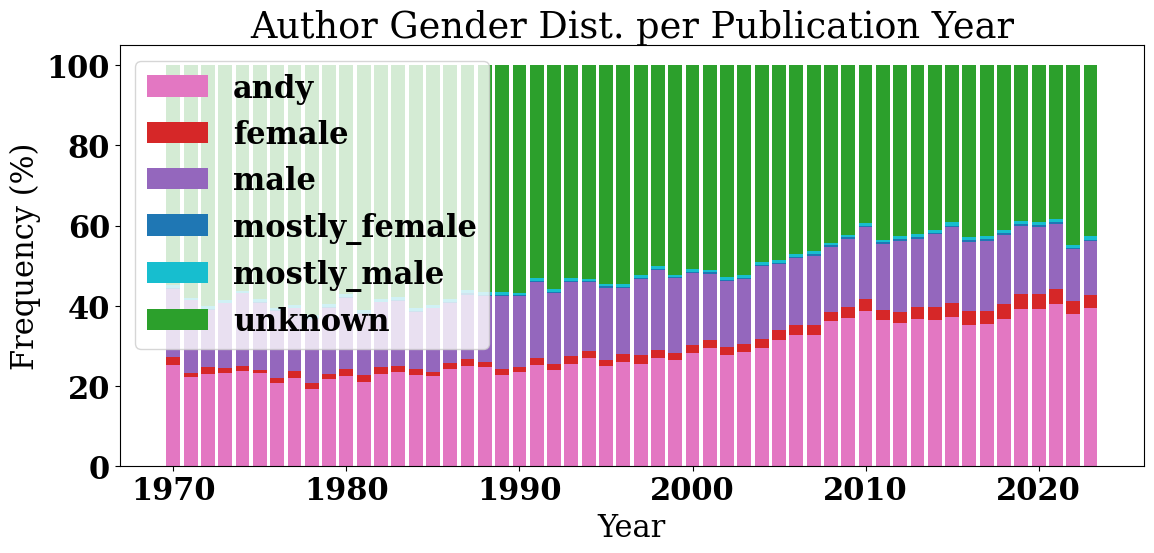

In [1175]:
#calculate gender dist per year 
gender_year_counts = article_author_data.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)')


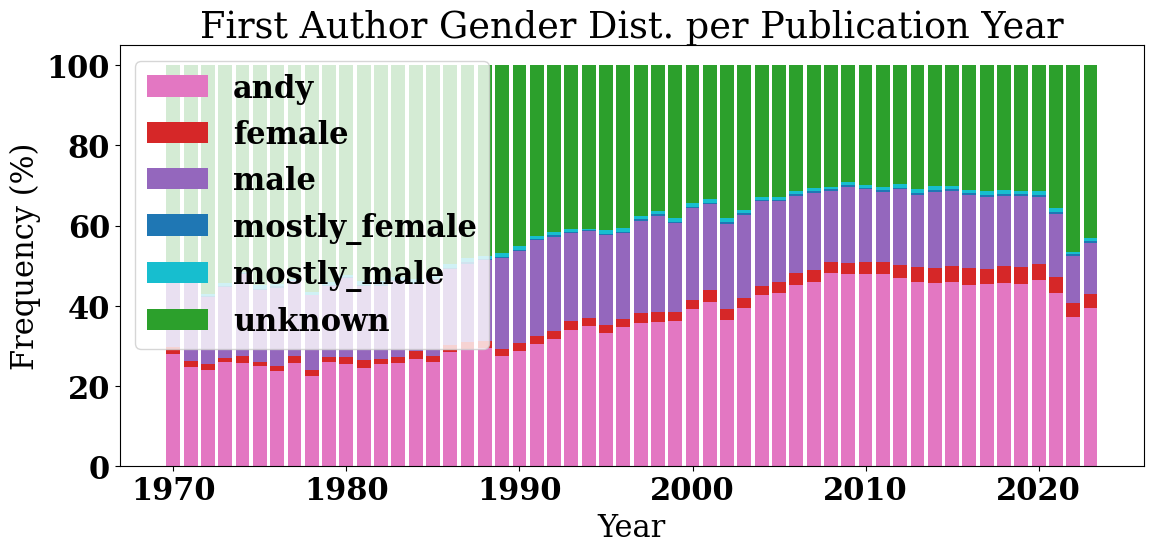

In [1177]:
#calculate gender dist per year 
first_author_gender_year_counts = first_author_article_data.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(first_author_gender_year_counts, 'publication_year', gender_year_counts.columns.difference(['publication_year']), title='First Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)')


## Clean gender assignment 

In [22]:
article_author_data['author_first_country'] = article_author_data['author_countries'].apply(lambda x: x[0] if len(x[0])==2 else x)


In [23]:
andy_gender=article_author_data[article_author_data['predicted_gender']=='andy']
unknown_gender=article_author_data[article_author_data['predicted_gender']=='unknown']

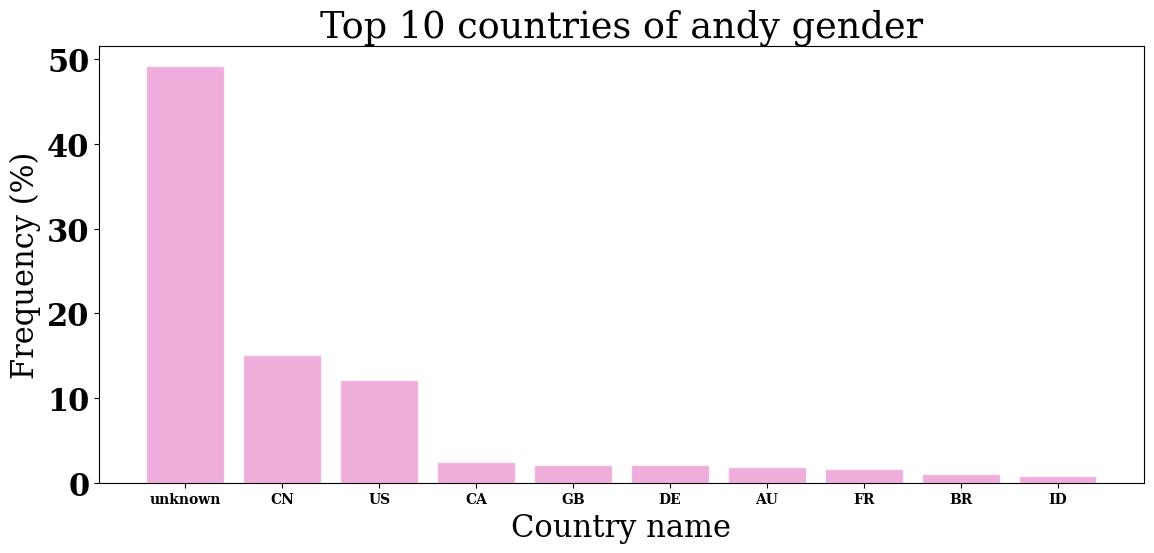

In [1180]:
cat10_plot(andy_gender.author_first_country, title='Top 10 countries of andy gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None)


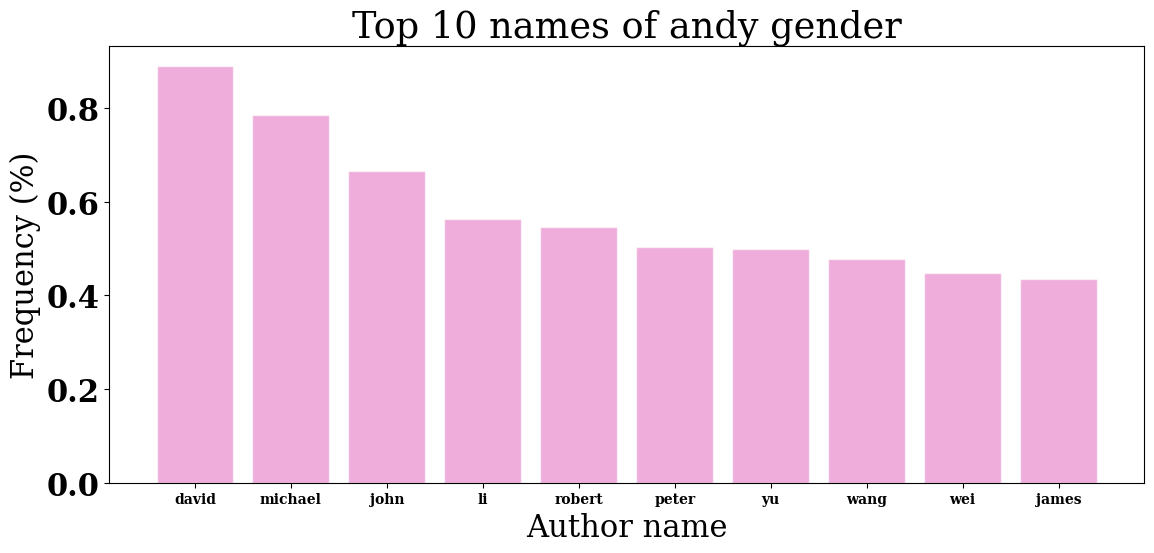

In [1181]:
cat10_plot(andy_gender.extracted_first_name, title='Top 10 names of andy gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None)



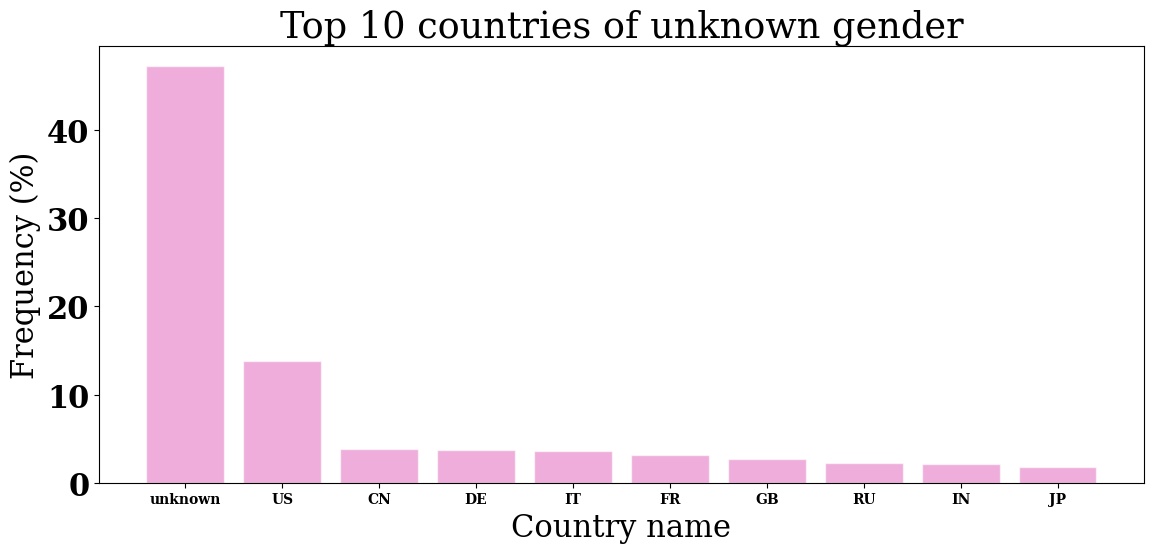

In [1182]:
cat10_plot(unknown_gender.author_first_country, title='Top 10 countries of unknown gender', xlabel='Country name', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None)


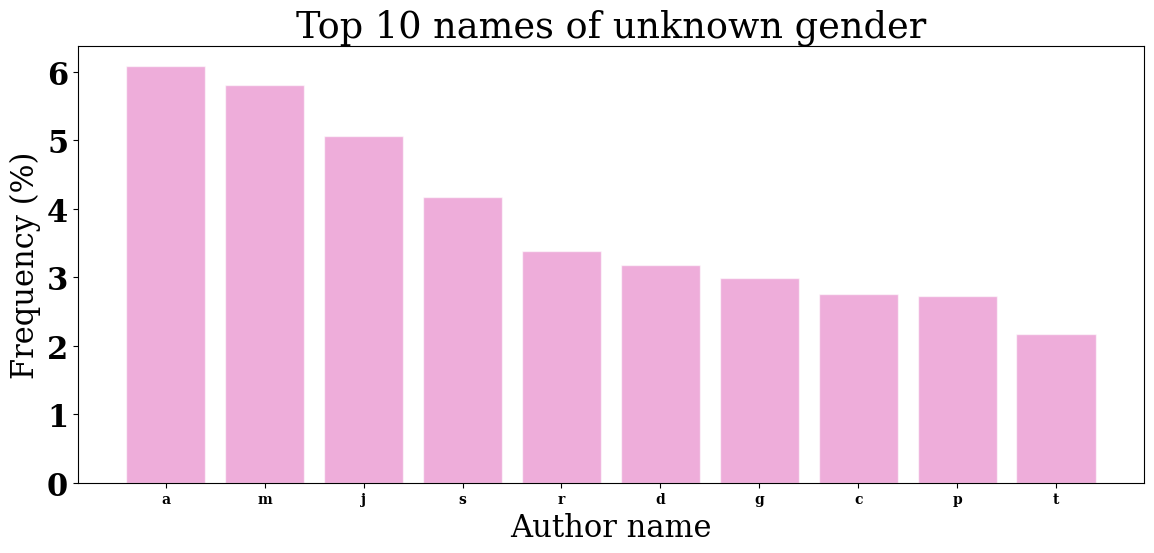

In [1183]:
cat10_plot(unknown_gender.extracted_first_name, title='Top 10 names of unknown gender', xlabel='Author name', ylabel='Frequency (%)', norm=True, multiply=100, xmargins=None)


In [24]:
#select data with an actual predicted gender 
author_data_gender=article_author_data[article_author_data['predicted_gender'].isin(['male', 'female', 'mostly_male', 'mostly_female'])]

In [25]:
len(author_data_gender)

414008

In [26]:
author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_male']='male'
author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_female']='female'

/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_24124/1767907793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_male']='male'
/var/folders/23/_5nwl30d12q_2dv4hhpqjfl00000gn/T/ipykernel_24124/1767907793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data_gender['predicted_gender'][author_data_gender['predicted_gender']=='mostly_female']='female'


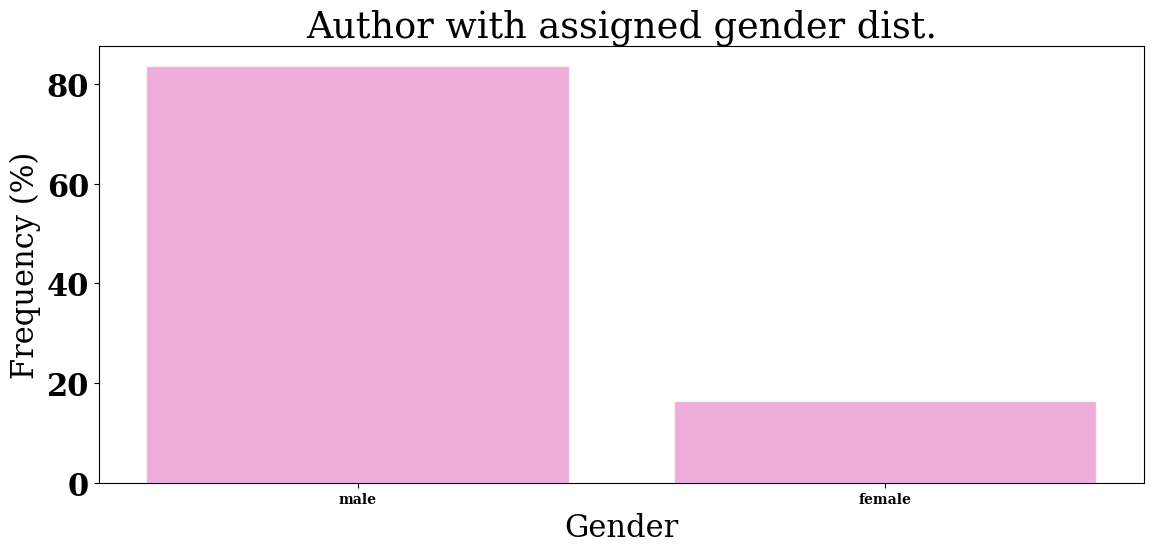

In [1187]:
cat_plot(author_data_gender.predicted_gender, title='Author with assigned gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, xmargins=None)


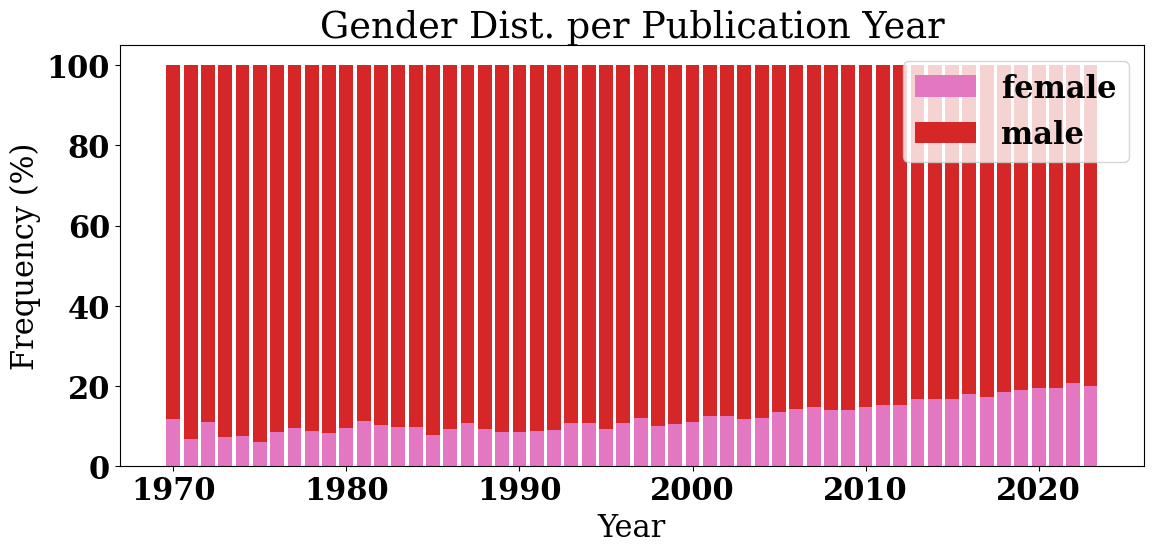

In [1188]:
#calculate gender dist per year 
binary_gender_year_counts = author_data_gender.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(binary_gender_year_counts, 'publication_year', binary_gender_year_counts.columns.difference(['publication_year']), title='Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)')


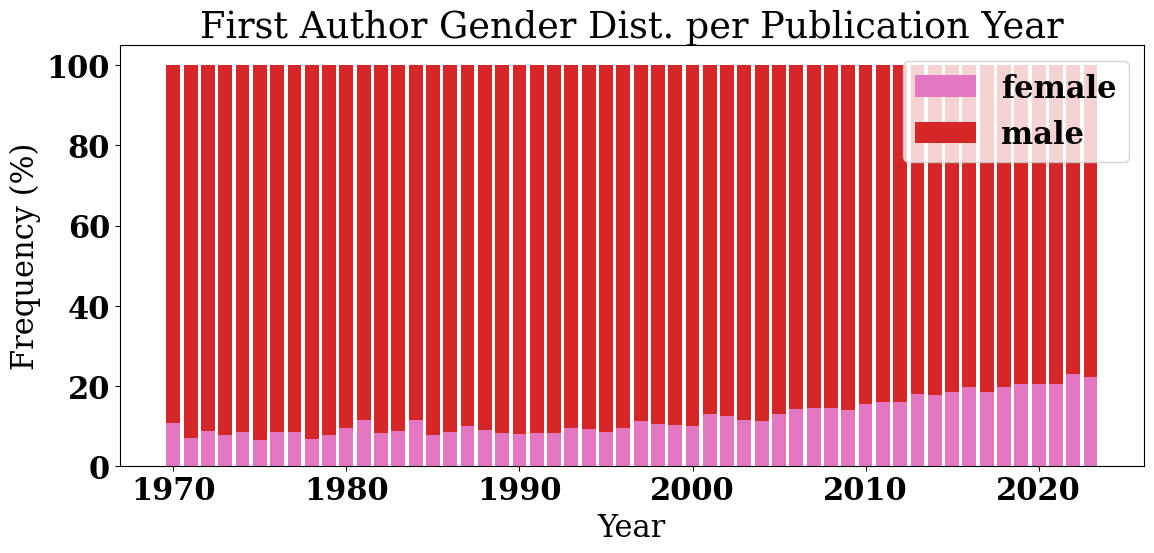

In [1192]:
#get first authors with an assigned gender
first_author_data_gender=author_data_gender[author_data_gender['author_position']=='first']

#calculate gender dist per year 
first_author_binary_gender_year_counts = first_author_data_gender.groupby(['publication_year', 'predicted_gender']).size().unstack(fill_value=0).reset_index()

#plot in stacked bar plot
stacked_bar_plot_normalized(first_author_binary_gender_year_counts, 'publication_year', first_author_binary_gender_year_counts.columns.difference(['publication_year']), title='First Author Gender Dist. per Publication Year', xlabel='Year', ylabel='Frequency (%)')


In [27]:
gender_article_counts = author_data_gender.groupby(['article_id', 'predicted_gender']).size().unstack(fill_value=0).reset_index()


In [28]:
gender_article_counts['total']=gender_article_counts['female']+gender_article_counts['male']
gender_article_counts['female_prct']=gender_article_counts['female']/gender_article_counts['total']*100
gender_article_counts['male_prct']=gender_article_counts['male']/gender_article_counts['total']*100



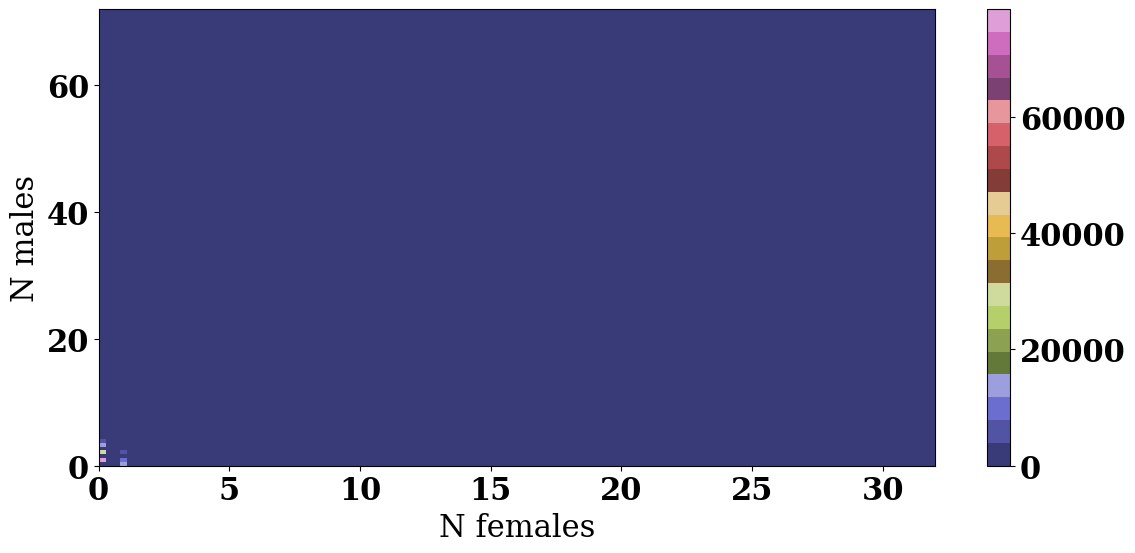

In [1195]:
plt.hist2d(gender_article_counts['female'], gender_article_counts['male'], bins=120, cmap='tab20b')
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.colorbar()
plt.xlabel('N females')
plt.ylabel('N males')
#plt.savefig('Plots/22102023/gender2dhist.png')
plt.show()


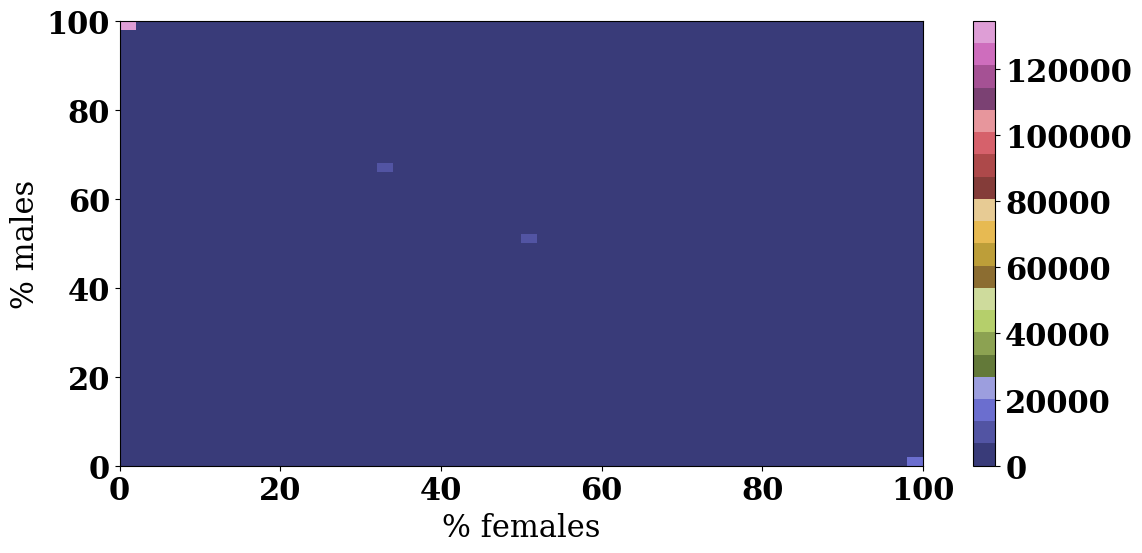

In [1196]:
plt.hist2d(gender_article_counts['female_prct'], gender_article_counts['male_prct'], bins=50, cmap='tab20b')
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.colorbar()
plt.xlabel('% females')
plt.ylabel('% males')
#plt.savefig('Plots/22102023/gender2dhist.png')
plt.show()


## Update unknown/andy country and gender

In [353]:
#check if the IDs assigned with unknown/andy appears multiple places in the data where we can get their data from 

In [354]:
duplicate_andy = andy_gender[andy_gender['author.id'].duplicated()]['author.id']

In [356]:
duplicate_andy=article_author_data[article_author_data['author_id'].isin(duplicate_andy.to_list())]
duplicate_andy = duplicate_andy.sort_values(by='author_id')


In [357]:
duplicate_andy['author_id'].value_counts()

author_id
https://openalex.org/A5041573207    332
https://openalex.org/A5052011846    207
https://openalex.org/A5045096283    184
https://openalex.org/A5009221549    182
https://openalex.org/A5086528441    179
                                   ... 
https://openalex.org/A5046536478      2
https://openalex.org/A5046536604      2
https://openalex.org/A5046536974      2
https://openalex.org/A5046539472      2
https://openalex.org/A5092826066      2
Name: count, Length: 115113, dtype: int64

In [91]:
#test example marco polini
testmarco=duplicate_andy[duplicate_andy['author.id']=='https://openalex.org/A5000001854']

In [92]:
testmarco #this is the same author and we actually have both country and gender info on him just in different rows

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,country_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
270915,https://openalex.org/W2517812354,None,2002,2002-01-01,Coherent transport in a Bose-Einstein condensa...,1,[],Experiments on atomic Bose-Einstein condensate...,None,None,...,unknown,unknown,unknown,marco polini,marco,other_countries,other_countries,other_countries,andy,unknown
1274281,https://openalex.org/W2904572026,https://doi.org/10.1103/physrevb.99.205437,2019,2019-05-30,Quantum versus classical many-body batteries,86,[],Quantum batteries are quantum mechanical syste...,https://openalex.org/S164183727,Outlook on Agriculture,...,Italian Institute of Technology,https://openalex.org/I30771326,facility,marco polini,marco,italy,italy,italy,male,IT
633733,https://openalex.org/W1782465517,https://doi.org/10.1103/physrevb.83.115135,2011,2011-03-29,Plasmon mass and Drude weight in strongly spin...,37,"[{'award_id': None, 'funder': 'https://openale...",Spin-orbit-coupled two-dimensional electron ga...,https://openalex.org/S4210228582,Physica status solidi,...,Kavli Institute for Theoretical Sciences,https://openalex.org/I4210105842,facility,marco polini,marco,china,china,china,andy,CN
429063,https://openalex.org/W2048628524,https://doi.org/10.1016/j.ssc.2007.04.035,2007,2007-07-01,Graphene: A pseudochiral Fermi liquid,103,[],Doped graphene sheets are pseudochiral two-dim...,https://openalex.org/S180907581,Physics Today,...,Scuola Normale Superiore,https://openalex.org/I157210198,education,marco polini,marco,italy,italy,italy,male,IT
389477,https://openalex.org/W2086234510,https://doi.org/10.1103/physrevb.73.165120,2006,2006-04-21,Bethe ansatz density-functional theory of ultr...,82,[],We present an extensive numerical study of gro...,https://openalex.org/S3880285,Science,...,Scuola Normale Superiore,https://openalex.org/I157210198,education,marco polini,marco,italy,italy,italy,male,IT
1010669,https://openalex.org/W2207174027,https://doi.org/10.1103/physrevb.93.125417,2016,2016-03-14,Resonant tunneling and the quasiparticle lifet...,16,"[{'award_id': None, 'funder': 'https://openale...",Tunneling of quasiparticles between two nearly...,https://openalex.org/S4210171743,Radiation effects,...,Italian Institute of Technology,https://openalex.org/I30771326,facility,marco polini,marco,italy,italy,italy,male,IT
1279190,https://openalex.org/W2810739219,https://doi.org/10.1103/physrevlett.122.016601,2019,2019-01-02,Failure of Conductance Quantization in Two-Dim...,58,"[{'award_id': '785219', 'funder': 'https://ope...",Despite topological protection and the absence...,https://openalex.org/S137773608,Nature,...,Italian Institute of Technology,https://openalex.org/I30771326,facility,marco polini,marco,united kingdom,united kingdom,great_britain,andy,GB
890035,https://openalex.org/W2092914796,https://doi.org/10.1117/12.2041462,2014,2014-03-07,THz detection in graphene nanotransistors,0,[],Nanotransistors offer great prospect for the d...,None,None,...,Istituto Nanoscienze,https://openalex.org/I4210087815,facility,marco polini,marco,italy,italy,italy,male,IT
1534595,https://openalex.org/W3120909184,https://doi.org/10.1063/5.0030869,2021,2021-01-04,Coherent terahertz radiation from a nonlinear ...,16,"[{'award_id': 'GBMF4302', 'funder': 'https://o...",Compressible electron flow through a narrow ca...,https://openalex.org/S67807940,ZAMM - Journal of Applied Mathematics and Mech...,...,University of Pisa,https://openalex.org/I108290504,education,marco polini,marco,united kingdom,united kingdom,great_britain,andy,GB
702605,https://openalex.org/W2168351239,https://doi.org/10.1103/physreva.86.063631,2012,2012-12-26,Spin transport in a unitary Fermi gas close to...,14,"[{'award_id': None, 'funder': 'https://openale...",We consider spin transport in a two-

In [51]:
#we create a function to update our data according to the value that appears the most per author since this must be the most accurate
#howevever if the value is unknown, other_countries or andy, we want to update with the secon most common value 

def update_author_info(dataframe, columns_to_update):
    most_common_values = dataframe[columns_to_update].apply(lambda x: x.value_counts().idxmax())
    dataframe_updated = dataframe.copy()

    for col in columns_to_update:
        most_common_val = most_common_values[col]

        # Check if most_common_val is in the specified list
        if most_common_val in ['unknown', 'andy', 'other_countries']:
            # Get unique values for the column
            unique_values = dataframe[col].unique()

            # Check if there are at least two unique values
            if len(unique_values) > 1:
                # Get the second most common value
                second_most_common_val = dataframe[col].value_counts().index[1]
                dataframe_updated[col] = dataframe_updated[col].replace(most_common_val, second_most_common_val)
    
    return dataframe_updated

columns_to_update = ['selected_full_name', 'extracted_first_name','author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [55]:
#let's check how long each step takes 
import time

def update_author_info(dataframe, columns_to_update):
    # Record the start time
    start_time = time.time()

    most_common_values = dataframe[columns_to_update].apply(lambda x: x.value_counts().idxmax()) #this is the part that takes the longest 
    dataframe_updated = dataframe.copy()

    # Record the time after the first part
    mid_time = time.time()

    for col in columns_to_update:
        most_common_val = most_common_values[col]

        if most_common_val in ['unknown', 'andy', 'other_countries']:
            unique_values = dataframe[col].unique()

            if len(unique_values) > 1:
                second_most_common_val = dataframe[col].value_counts().index[1]
                dataframe_updated[col] = dataframe_updated[col].replace(most_common_val, second_most_common_val)

    # Record the time after the second part
    end_time = time.time()

    # Calculate the time taken for each part
    time_part1 = mid_time - start_time
    time_part2 = end_time - mid_time

    # Print the results
    print(f"Time for Part 1: {time_part1} seconds")
    print(f"Time for Part 2: {time_part2} seconds")

    return dataframe_updated

columns_to_update = ['selected_full_name', 'extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [62]:
test10 = article_author_data.sample(n=10)


In [63]:
len(test10)

10

In [64]:
%%time

test10_updated = test10.groupby('author.id').apply(lambda group: update_author_info(group, columns_to_update)).reset_index(drop=True)


Time for Part 1: 4.682806015014648 seconds
Time for Part 2: 0.0038018226623535156 seconds
Time for Part 1: 3.141908884048462 seconds
Time for Part 2: 0.001547098159790039 seconds
Time for Part 1: 3.8923630714416504 seconds
Time for Part 2: 0.011442184448242188 seconds
Time for Part 1: 3.9041287899017334 seconds
Time for Part 2: 0.001049041748046875 seconds
Time for Part 1: 3.5773119926452637 seconds
Time for Part 2: 0.00031280517578125 seconds
Time for Part 1: 3.5391812324523926 seconds
Time for Part 2: 0.0015060901641845703 seconds
Time for Part 1: 3.0742361545562744 seconds
Time for Part 2: 0.003155946731567383 seconds
Time for Part 1: 3.2976431846618652 seconds
Time for Part 2: 0.0030536651611328125 seconds
Time for Part 1: 4.178512096405029 seconds
Time for Part 2: 0.0015017986297607422 seconds
Time for Part 1: 3.6425740718841553 seconds
Time for Part 2: 0.0007891654968261719 seconds
CPU times: user 992 ms, sys: 7.65 s, total: 8.64 s
Wall time: 44.3 s


In [65]:
len(article_author_data)/10*44.3

8861244.83

In [66]:
#test modified version in time - we have updated part 1 as this took the longest to calculate

def update_author_info_modi(dataframe, columns_to_update):
    # Record the start time
    start_time = time.time()

    # Calculate value counts for each column (grouped per id)
    value_counts_dict = {col: dataframe[col].value_counts().idxmax() for col in columns_to_update}

    # Record the time after calculating value counts 
    mid_time = time.time()

    most_common_values = dataframe[columns_to_update].apply(lambda x: value_counts_dict[x.name])

    # Record the time after the first part
    end_time = time.time()

    dataframe_updated = dataframe.copy()

    for col in columns_to_update:
        most_common_val = most_common_values[col]

        if most_common_val in ['unknown', 'andy', 'other_countries']:
            unique_values = dataframe[col].unique()

            if len(unique_values) > 1:
                second_most_common_val = dataframe[col].value_counts().index[1]
                dataframe_updated[col] = dataframe_updated[col].replace(most_common_val, second_most_common_val)

    # Calculate the time taken for each part
    time_part1 = mid_time - start_time
    time_part2 = end_time - mid_time
 
    print(f"Time for Part 1: {time_part1} seconds")
    print(f"Time for Part 2: {time_part2} seconds")

    return dataframe_updated

columns_to_update = ['selected_full_name', 'extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']



In [67]:
%%time

test10_updated_modi = test10.groupby('author.id').apply(lambda group: update_author_info_modi(group, columns_to_update)).reset_index(drop=True)


Time for Part 1: 0.00461268424987793 seconds
Time for Part 2: 0.003306150436401367 seconds
Time for Part 1: 0.0017778873443603516 seconds
Time for Part 2: 0.0011248588562011719 seconds
Time for Part 1: 0.0023076534271240234 seconds
Time for Part 2: 0.0010330677032470703 seconds
Time for Part 1: 0.0016300678253173828 seconds
Time for Part 2: 0.0010209083557128906 seconds
Time for Part 1: 0.0023207664489746094 seconds
Time for Part 2: 0.0007081031799316406 seconds
Time for Part 1: 0.0024099349975585938 seconds
Time for Part 2: 0.0007612705230712891 seconds
Time for Part 1: 0.0060160160064697266 seconds
Time for Part 2: 0.0019268989562988281 seconds
Time for Part 1: 0.0014929771423339844 seconds
Time for Part 2: 0.0018720626831054688 seconds
Time for Part 1: 0.001711130142211914 seconds
Time for Part 2: 0.0013427734375 seconds
Time for Part 1: 0.0030329227447509766 seconds
Time for Part 2: 0.0027320384979248047 seconds
CPU times: user 935 ms, sys: 7.14 s, total: 8.08 s
Wall time: 27.1 s


In [69]:
len(article_author_data)/len(test10)*27.1

5420761.510000001

In [72]:
test10

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_country_code,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
802053,https://openalex.org/W1994087891,https://doi.org/10.1016/j.nuclphysa.2012.12.075,2013,2013-09-01,"The <mml:math xmlns:mml=""http://www.w3.org/199...",1,[],"A Bayesian analysis of the world's $p(\gamma,K...",https://openalex.org/S117777261,Nuclear Science and Engineering,...,BE,Ghent University,https://openalex.org/I32597200,education,pieter vancraeyveld,pieter,belgium,belgium,male,BE
1127678,https://openalex.org/W2580873340,https://doi.org/10.1038/srep41301,2017,2017-01-25,Persistence of strong and switchable ferroelec...,5,[],Abstract Vacancies play a pivotal role in affe...,https://openalex.org/S32204141,Physik in unserer Zeit,...,US,Rensselaer Polytechnic Institute,https://openalex.org/I165799507,education,aldo raeliarijaona,aldo,united states,usa,andy,US
675784,https://openalex.org/W2962890396,https://doi.org/10.1109/cleoe.2011.5943434,2011,2011-05-01,Remote entanglement between a single atom and ...,0,[],Entanglement has been recognised as a puzzling...,https://openalex.org/S4210174675,Physical review,...,DE,Max Planck Institute of Quantum Optics,https://openalex.org/I4210120293,facility,carolin hahn,carolin,germany,germany,female,DE
443794,https://openalex.org/W1991121362,https://doi.org/10.14494/jnrs2000.8.59,2007,2007-01-01,Development of On-line Solvent Extraction Syst...,7,[],A technique of microchip chemistry was introdu...,https://openalex.org/S140889577,Journal of Applied Physiology,...,JP,Osaka University,https://openalex.org/I98285908,education,takahiro kuribayashi,takahiro,japan,japan,male,JP
1659210,https://openalex.org/W3202323139,None,2021,2021-10-04,The CaloCube calorimeter for high-energy cosmi...,0,[],The direct observation of high-energy cosmic r...,https://openalex.org/S95132780,Science Activities: Classroom Projects and Cur...,...,unknown,unknown,unknown,unknown,l. bonechi,l,other_countries,other_countries,unknown,unknown
1202270,https://openalex.org/W2787560744,https://doi.org/10.1080/05568641.2018.1429739,2018,2018-01-02,Linguistic Privilege and Justice: What Can We ...,13,[],The linguistic privilege of native speakers in...,https://openalex.org/S62401924,Journal of the American Statistical Association,...,US,Fermi National Accelerator Laboratory,https://openalex.org/I1314696892,facility,vitaly pronskikh,vitaly,united states,usa,andy,US
463727,https://openalex.org/W66786632,https://doi.org/10.22323/1.021.0021,2007,2007-04-24,Very High Energy Gamma Ray Astronomy and Cosmi...,0,[],"Gamma ray astronomy at energies 1011 1013 eV, ...",https://openalex.org/S8802318,Annals of the New York Academy of Sciences,...,unknown,unknown,unknown,unknown,cc ning,cc,other_countries,other_countries,unknown,unknown
1297415,https://openalex.org/W2898523942,https://doi.org/10.1016/j.ijthermalsci.2018.10...,2019,2019-02-01,Investigation of thermal responses during meta...,18,"[{'award_id': '51621004', 'funder': 'https://o...",Abstract Temperature distribution and thermal ...,https://openalex.org/S147269504,Journal of Polymer Science: Polymer Letters Ed...,...,CN,Hunan University,https://openalex.org/I16609230,education,she li,she,china,china,unknown,CN
561114,https://openalex.org/W2953010453,None,2009,2009-05-15,The PAMELA Space Experiment,0,[],"The 15th of June 2006, the PAMELA satellite-bo...",https://openalex.org/S44796280,Sciences-new York,...,unknown,unknown,unknown,unknown,m. bongi,m,other_countries,other_countries,unknown,unknown
1549342,https://openalex.org/W3121513723,https://doi.org/10.3847/1538-4357/abd7e9,2021,2021-02-01,A Census of Blue Stragglers in Gaia DR2 Open C...,17,"[{'award_id': 'AST-1801937', 'funder': 'https:...",Abstract We use photometry and proper motions ...,https://openalex.org/S13777

In [143]:
#rename author.id to make it easier to work with 
test10 = test10.rename(columns={'author.id': 'author_id'})


In [241]:
#we modify our function to work faster and better. 
#It groups the dataframe by author ID and updates specified columns with the most common non-'unknown' or non-'andy' 
#values within each author's records for the respective column. 
#The function ensures that the update is performed independently for each author, avoiding global column updates.

def update_author_info_modified(dataframe, columns_to_update):
    # Reset the index to ensure 'author_id' is treated as a regular column
    dataframe = dataframe.reset_index(drop=True)

    dataframe_updated = dataframe.copy()

    # Group by author_id and iterate over each group
    grouped = dataframe.groupby('author_id')
    for author_id, group in grouped:
        # Check if the group has any valid values
        if not group.empty:
            # Calculate most common values within the current group
            most_common_values = {col: group[col].value_counts().idxmax() for col in columns_to_update if not group[col].isin(['unknown', 'andy']).all()}

            # Update values only within the current group
            for col in columns_to_update:
                most_common_val = most_common_values.get(col, None)

                if most_common_val is not None:
                    dataframe_updated.loc[dataframe_updated['author_id'] == author_id, col] = most_common_val

    return dataframe_updated


columns_to_update = ['selected_full_name', 'extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [279]:
#here we add the part about replacing with the second most common value in case the first is unknown/andy

def update_author_info_modified_second(dataframe, columns_to_update):
    # Reset the index to ensure 'author_id' is treated as a regular column
    dataframe = dataframe.reset_index(drop=True)

    dataframe_updated = dataframe.copy()

    # Group by author_id and iterate over each group
    grouped = dataframe.groupby('author_id')
    for author_id, group in grouped:
        # Check if the group has any valid values
        if not group.empty:
            # Calculate most common values within the current group
            most_common_values = {col: group[col].value_counts().idxmax() for col in columns_to_update if not group[col].isin(['unknown', 'andy']).all()}

            # Update values only within the current group
            for col in columns_to_update:
                most_common_val = most_common_values.get(col, None)

                if most_common_val is not None:
                    # If most common value is 'unknown' or 'andy', replace it with the second most common value
                    if most_common_val in ['unknown', 'andy', 'other_countries']:
                        second_most_common_val = group[col].value_counts().index[1] if len(group[col].unique()) > 1 else None
                        if second_most_common_val is not None:
                            dataframe_updated.loc[dataframe_updated['author_id'] == author_id, col] = second_most_common_val

    return dataframe_updated


columns_to_update = ['selected_full_name', 'extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [242]:
%%time

test10_updated_modified = update_author_info_modified(test10, columns_to_update)


CPU times: user 34.6 ms, sys: 4.5 ms, total: 39.1 ms
Wall time: 36.7 ms


In [186]:
test10_updated_modified['author_id'].nunique()

10

In [132]:
test10

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_country_code,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
802053,https://openalex.org/W1994087891,https://doi.org/10.1016/j.nuclphysa.2012.12.075,2013,2013-09-01,"The <mml:math xmlns:mml=""http://www.w3.org/199...",1,[],"A Bayesian analysis of the world's $p(\gamma,K...",https://openalex.org/S117777261,Nuclear Science and Engineering,...,BE,Ghent University,https://openalex.org/I32597200,education,pieter vancraeyveld,pieter,belgium,belgium,male,BE
1127678,https://openalex.org/W2580873340,https://doi.org/10.1038/srep41301,2017,2017-01-25,Persistence of strong and switchable ferroelec...,5,[],Abstract Vacancies play a pivotal role in affe...,https://openalex.org/S32204141,Physik in unserer Zeit,...,US,Rensselaer Polytechnic Institute,https://openalex.org/I165799507,education,aldo raeliarijaona,aldo,united states,usa,andy,US
675784,https://openalex.org/W2962890396,https://doi.org/10.1109/cleoe.2011.5943434,2011,2011-05-01,Remote entanglement between a single atom and ...,0,[],Entanglement has been recognised as a puzzling...,https://openalex.org/S4210174675,Physical review,...,DE,Max Planck Institute of Quantum Optics,https://openalex.org/I4210120293,facility,carolin hahn,carolin,germany,germany,female,DE
443794,https://openalex.org/W1991121362,https://doi.org/10.14494/jnrs2000.8.59,2007,2007-01-01,Development of On-line Solvent Extraction Syst...,7,[],A technique of microchip chemistry was introdu...,https://openalex.org/S140889577,Journal of Applied Physiology,...,JP,Osaka University,https://openalex.org/I98285908,education,takahiro kuribayashi,takahiro,japan,japan,male,JP
1659210,https://openalex.org/W3202323139,None,2021,2021-10-04,The CaloCube calorimeter for high-energy cosmi...,0,[],The direct observation of high-energy cosmic r...,https://openalex.org/S95132780,Science Activities: Classroom Projects and Cur...,...,unknown,unknown,unknown,unknown,l. bonechi,l,other_countries,other_countries,unknown,unknown
1202270,https://openalex.org/W2787560744,https://doi.org/10.1080/05568641.2018.1429739,2018,2018-01-02,Linguistic Privilege and Justice: What Can We ...,13,[],The linguistic privilege of native speakers in...,https://openalex.org/S62401924,Journal of the American Statistical Association,...,US,Fermi National Accelerator Laboratory,https://openalex.org/I1314696892,facility,vitaly pronskikh,vitaly,united states,usa,andy,US
463727,https://openalex.org/W66786632,https://doi.org/10.22323/1.021.0021,2007,2007-04-24,Very High Energy Gamma Ray Astronomy and Cosmi...,0,[],"Gamma ray astronomy at energies 1011 1013 eV, ...",https://openalex.org/S8802318,Annals of the New York Academy of Sciences,...,unknown,unknown,unknown,unknown,cc ning,cc,other_countries,other_countries,unknown,unknown
1297415,https://openalex.org/W2898523942,https://doi.org/10.1016/j.ijthermalsci.2018.10...,2019,2019-02-01,Investigation of thermal responses during meta...,18,"[{'award_id': '51621004', 'funder': 'https://o...",Abstract Temperature distribution and thermal ...,https://openalex.org/S147269504,Journal of Polymer Science: Polymer Letters Ed...,...,CN,Hunan University,https://openalex.org/I16609230,education,she li,she,china,china,unknown,CN
561114,https://openalex.org/W2953010453,None,2009,2009-05-15,The PAMELA Space Experiment,0,[],"The 15th of June 2006, the PAMELA satellite-bo...",https://openalex.org/S44796280,Sciences-new York,...,unknown,unknown,unknown,unknown,m. bongi,m,other_countries,other_countries,unknown,unknown
1549342,https://openalex.org/W3121513723,https://doi.org/10.3847/1538-4357/abd7e9,2021,2021-02-01,A Census of Blue Stragglers in Gaia DR2 Open C...,17,"[{'award_id': 'AST-1801937', 'funder': 'https:...",Abstract We use photometry and proper motions ...,https://openalex.org/S13777

In [243]:
test10_updated_modified

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_country_code,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
0,https://openalex.org/W1994087891,https://doi.org/10.1016/j.nuclphysa.2012.12.075,2013,2013-09-01,"The <mml:math xmlns:mml=""http://www.w3.org/199...",1,[],"A Bayesian analysis of the world's $p(\gamma,K...",https://openalex.org/S117777261,Nuclear Science and Engineering,...,BE,Ghent University,https://openalex.org/I32597200,education,pieter vancraeyveld,pieter,belgium,belgium,male,BE
1,https://openalex.org/W2580873340,https://doi.org/10.1038/srep41301,2017,2017-01-25,Persistence of strong and switchable ferroelec...,5,[],Abstract Vacancies play a pivotal role in affe...,https://openalex.org/S32204141,Physik in unserer Zeit,...,US,Rensselaer Polytechnic Institute,https://openalex.org/I165799507,education,aldo raeliarijaona,aldo,united states,usa,andy,US
2,https://openalex.org/W2962890396,https://doi.org/10.1109/cleoe.2011.5943434,2011,2011-05-01,Remote entanglement between a single atom and ...,0,[],Entanglement has been recognised as a puzzling...,https://openalex.org/S4210174675,Physical review,...,DE,Max Planck Institute of Quantum Optics,https://openalex.org/I4210120293,facility,carolin hahn,carolin,germany,germany,female,DE
3,https://openalex.org/W1991121362,https://doi.org/10.14494/jnrs2000.8.59,2007,2007-01-01,Development of On-line Solvent Extraction Syst...,7,[],A technique of microchip chemistry was introdu...,https://openalex.org/S140889577,Journal of Applied Physiology,...,JP,Osaka University,https://openalex.org/I98285908,education,takahiro kuribayashi,takahiro,japan,japan,male,JP
4,https://openalex.org/W3202323139,None,2021,2021-10-04,The CaloCube calorimeter for high-energy cosmi...,0,[],The direct observation of high-energy cosmic r...,https://openalex.org/S95132780,Science Activities: Classroom Projects and Cur...,...,unknown,unknown,unknown,unknown,l. bonechi,l,other_countries,other_countries,unknown,unknown
5,https://openalex.org/W2787560744,https://doi.org/10.1080/05568641.2018.1429739,2018,2018-01-02,Linguistic Privilege and Justice: What Can We ...,13,[],The linguistic privilege of native speakers in...,https://openalex.org/S62401924,Journal of the American Statistical Association,...,US,Fermi National Accelerator Laboratory,https://openalex.org/I1314696892,facility,vitaly pronskikh,vitaly,united states,usa,andy,US
6,https://openalex.org/W66786632,https://doi.org/10.22323/1.021.0021,2007,2007-04-24,Very High Energy Gamma Ray Astronomy and Cosmi...,0,[],"Gamma ray astronomy at energies 1011 1013 eV, ...",https://openalex.org/S8802318,Annals of the New York Academy of Sciences,...,unknown,unknown,unknown,unknown,cc ning,cc,other_countries,other_countries,unknown,unknown
7,https://openalex.org/W2898523942,https://doi.org/10.1016/j.ijthermalsci.2018.10...,2019,2019-02-01,Investigation of thermal responses during meta...,18,"[{'award_id': '51621004', 'funder': 'https://o...",Abstract Temperature distribution and thermal ...,https://openalex.org/S147269504,Journal of Polymer Science: Polymer Letters Ed...,...,CN,Hunan University,https://openalex.org/I16609230,education,she li,she,china,china,unknown,CN
8,https://openalex.org/W2953010453,None,2009,2009-05-15,The PAMELA Space Experiment,0,[],"The 15th of June 2006, the PAMELA satellite-bo...",https://openalex.org/S44796280,Sciences-new York,...,unknown,unknown,unknown,unknown,m. bongi,m,other_countries,other_countries,unknown,unknown
9,https://openalex.org/W3121513723,https://doi.org/10.3847/1538-4357/abd7e9,2021,2021-02-01,A Census of Blue Stragglers in Gaia DR2 Open C...,17,"[{'award_id': 'AST-1801937', 'funder': 'https:...",Abstract We use photometry and proper motions ...,https://openalex.org/S137773608,Nature,...,US,Northwestern University,https://open

In [244]:
#rename author.id to make it easier to work with 
testmarco = testmarco.rename(columns={'author.id': 'author_id'})


In [245]:
%%time
testmarco_updated_modified = update_author_info_modified(testmarco, columns_to_update)


CPU times: user 8.84 ms, sys: 2.93 ms, total: 11.8 ms
Wall time: 10.2 ms


In [246]:
testmarco_updated_modified[['selected_full_name',	'extracted_first_name',	'country_name',	'author_country_name',	'author_country_name_api',	'predicted_gender',	'author_first_country']]



,selected_full_name,extracted_first_name,country_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
0,marco polini,marco,other_countries,italy,italy,male,IT
1,marco polini,marco,italy,italy,italy,male,IT
2,marco polini,marco,china,italy,italy,male,IT
3,marco polini,marco,italy,italy,italy,male,IT
4,marco polini,marco,italy,italy,italy,male,IT
5,marco polini,marco,italy,italy,italy,male,IT
6,marco polini,marco,united kingdom,italy,italy,male,IT
7,marco polini,marco,italy,italy,italy,male,IT
8,marco polini,marco,united kingdom,italy,italy,male,IT
9,marco polini,marco,italy,italy,italy,male,IT


In [248]:
# Print unique values in the specified columns before the update
print("Before Update:")
for col in columns_to_update:
    print(f"Column: {col}")
    print(testmarco[col].value_counts())
    print()

testmarco_updated = update_author_info_modified(testmarco, columns_to_update)

# Print unique values in the specified columns after the update
print("After Update:")
for col in columns_to_update:
    print(f"Column: {col}")
    print(testmarco_updated[col].value_counts())
    print()


Before Update:
Column: selected_full_name
selected_full_name
marco polini     22
polini, marco     2
Name: count, dtype: int64

Column: extracted_first_name
extracted_first_name
marco     22
polini     2
Name: count, dtype: int64

Column: author_country_name
author_country_name
italy              11
other_countries     7
united kingdom      4
china               1
spain               1
Name: count, dtype: int64

Column: author_country_name_api
author_country_name_api
italy              11
other_countries     7
great_britain       4
china               1
spain               1
Name: count, dtype: int64

Column: predicted_gender
predicted_gender
male       12
andy       10
unknown     2
Name: count, dtype: int64

Column: author_first_country
author_first_country
IT         11
unknown     7
GB          4
CN          1
ES          1
Name: count, dtype: int64

After Update:
Column: selected_full_name
selected_full_name
marco polini    24
Name: count, dtype: int64

Column: extracted_first_nam

In [255]:
print("Estimated time to run function on complete dataframe:", f'{36.7/len(test10)*len(article_author_data)/3600000} h')

Estimated time to run function on complete dataframe: 2.039175352777778 h


In [273]:
#create a test with more andy than male so that we can check if the second condition of function works 
testdavid=duplicate_andy[duplicate_andy['author.id']=='https://openalex.org/A5000003309']
testdavid=testdavid[1:4]

In [274]:
#rename author.id to make it easier to work with 
testdavid = testdavid.rename(columns={'author.id': 'author_id'})


In [275]:
%%time
testdavid_updated_modified = update_author_info_modified(testdavid, columns_to_update)


CPU times: user 7.62 ms, sys: 6.12 ms, total: 13.7 ms
Wall time: 14.5 ms


In [276]:
testdavid_updated_modified[['selected_full_name',	'extracted_first_name',	'country_name',	'author_country_name',	'author_country_name_api',	'predicted_gender',	'author_first_country']]



,selected_full_name,extracted_first_name,country_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
0,david a. randall,david,united states,other_countries,other_countries,andy,unknown
1,david a. randall,david,other_countries,other_countries,other_countries,andy,unknown
2,david a. randall,david,other_countries,other_countries,other_countries,andy,unknown


In [280]:
%%time
testdavid_updated_modified_second = update_author_info_modified_second(testdavid, columns_to_update)


CPU times: user 9.33 ms, sys: 2.85 ms, total: 12.2 ms
Wall time: 9.64 ms


In [281]:
testdavid_updated_modified_second[['selected_full_name',	'extracted_first_name',	'country_name',	'author_country_name',	'author_country_name_api',	'predicted_gender',	'author_first_country']]


,selected_full_name,extracted_first_name,country_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
0,david a. randall,david,united states,united states,usa,male,US
1,"randall, david a.",randall,other_countries,united states,usa,male,US
2,david a. randall,david,other_countries,united states,usa,male,US


In [310]:
#Now let's try and create a bit larger sample and see how lang that takes to run the second version 
test5000 = article_author_data.sample(n=5000)
test1000 = article_author_data[1000:20001]
test5000 = test5000.rename(columns={'author.id': 'author_id'})
test1000 = test100.rename(columns={'author.id': 'author_id'})


In [299]:
#let's check how many cases of duplicates we actually have in the sample
test5000['author_id'].nunique()

4932

In [314]:
len(test1000)-test1000['author_id'].nunique()

3332

In [312]:
%%time
test1000_updated_modified_second = update_author_info_modified_second(test1000, columns_to_update)


CPU times: user 8.62 s, sys: 99.4 ms, total: 8.72 s
Wall time: 8.79 s


In [316]:
print("Estimated time to run function on complete dataframe:", f'{8.79/len(test1000)*len(article_author_data)/3600} h')

Estimated time to run function on complete dataframe: 0.2570401263968563 h


In [317]:
# Apply function to the whole dataset 
article_author_data = article_author_data.rename(columns={'author.id': 'author_id'})


In [318]:
%%time
article_author_data_updated = update_author_info_modified_second(article_author_data, columns_to_update)

CPU times: user 5h 14min 13s, sys: 1min 37s, total: 5h 15min 51s
Wall time: 5h 18min 46s


In [320]:
with open('Data backup/06122023UpdatedAuthorData19702023.pkl', 'wb') as f:
    pickle.dump(article_author_data_updated, f)

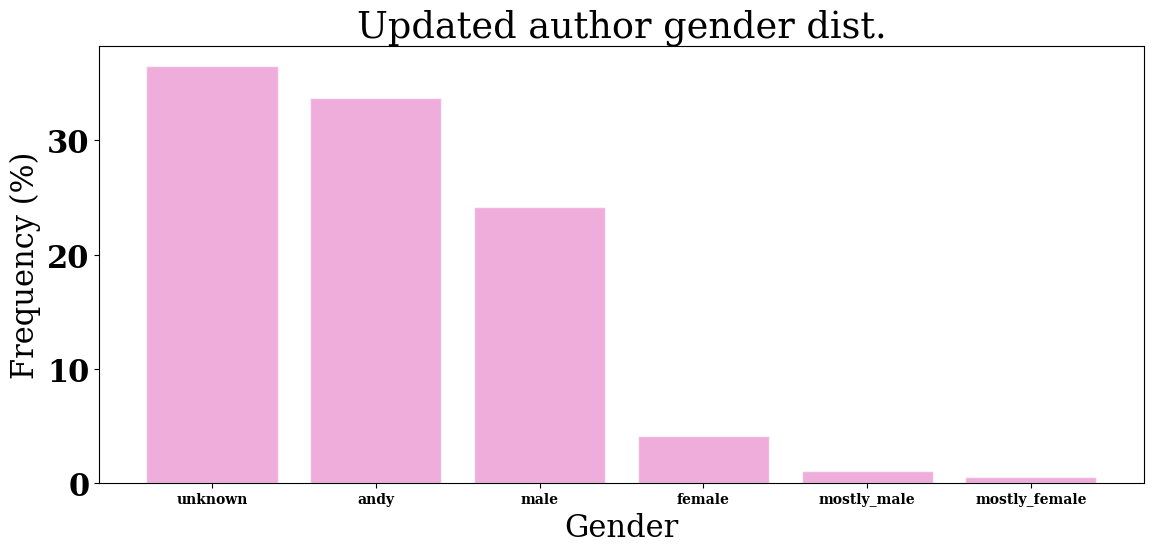

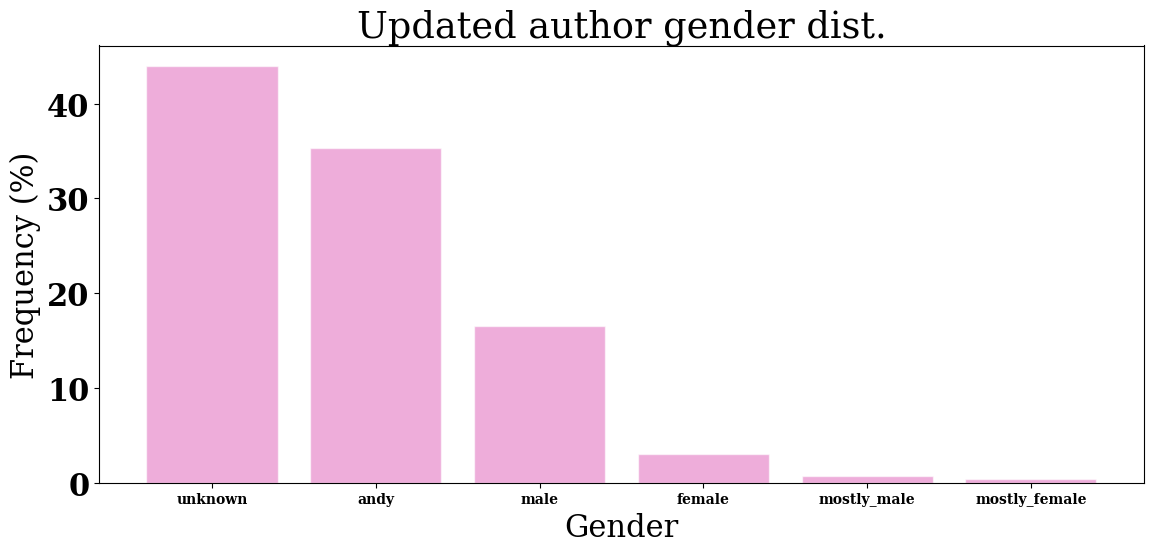

In [331]:
cat_plot(article_author_data_updated.predicted_gender, title='Updated author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, xmargins=None)
cat_plot(article_author_data.predicted_gender, title='Updated author gender dist.', xlabel='Gender', ylabel='Frequency (%)', norm=True, multiply=100, rot=0, xmargins=None)


In [ ]:
#check for duplicates in andy and unknown again since we still have alot unknown and andy 

In [340]:
andy_gender_upd=article_author_data_updated[article_author_data_updated['predicted_gender']=='andy']

In [341]:
duplicate_andy_upd = andy_gender_upd[andy_gender_upd['author_id'].duplicated()]['author_id']

In [342]:
duplicate_andy_upd=article_author_data_updated[article_author_data_updated['author_id'].isin(duplicate_andy_upd.to_list())]
duplicate_andy_upd = duplicate_andy_upd.sort_values(by='author_id')


In [343]:
duplicate_andy_upd['author_id'].value_counts()

author_id
https://openalex.org/A5041573207    332
https://openalex.org/A5052011846    207
https://openalex.org/A5045096283    184
https://openalex.org/A5009221549    182
https://openalex.org/A5086528441    179
                                   ... 
https://openalex.org/A5009854707      2
https://openalex.org/A5052012807      2
https://openalex.org/A5052013133      2
https://openalex.org/A5052014444      2
https://openalex.org/A5092826066      2
Name: count, Length: 101453, dtype: int64

In [351]:
testauthor=article_author_data_updated[article_author_data_updated['author_id']=='https://openalex.org/A5045096283']

In [352]:
testauthor['predicted_gender'].value_counts()

predicted_gender
male       97
unknown    45
andy       42
Name: count, dtype: int64

In [ ]:
#it looks like our function works but we forgot to add a different case - right now it only updates if the
#most common value IS andy or unknown - however what we actually want it to do is update each column with the most common value
# EXCEPT if it is andy/unknown/other_country - then it should choose second most common value 
#and if that is still andy/unknown/other_country then choose 3rd most common value 

In [404]:
def update_author_info_final(dataframe, columns_to_update):
    # Reset the index to ensure 'author_id' is treated as a regular column
    dataframe = dataframe.reset_index(drop=True)

    dataframe_updated = dataframe.copy()

    # Group by author_id and iterate over each group
    grouped = dataframe.groupby('author_id')
    for author_id, group in grouped:
        # Check if the group has any valid values
        if not group.empty:
            # Update values only within the current group
            for col in columns_to_update:
                # Count occurrences of each value in the group
                value_counts = group[col].value_counts()

                # Remove prohibited values from consideration
                non_prohibited_values = [val for val in value_counts.index if val not in ['unknown', 'andy', 'other_countries', 'none anonymous', 'none']]

                # If there are non-prohibited values, update with the most common non-prohibited value
                if non_prohibited_values:
                    most_common_val = non_prohibited_values[0]  # Initialize with the first non-prohibited value
                    for val in non_prohibited_values[1:]:
                        if value_counts[val] > value_counts[most_common_val]:
                            most_common_val = val
                    dataframe_updated.loc[dataframe_updated['author_id'] == author_id, col] = most_common_val

    return dataframe_updated


columns_to_update = ['selected_full_name', 'extracted_first_name', 'author_country_name', 'author_country_name_api', 'predicted_gender', 'author_first_country']


In [405]:
#Now let's test it out 
test1 = article_author_data.sample(n=100)
test2 = article_author_data[2000:5000]
test1 = test1.rename(columns={'author.id': 'author_id'})
test2 = test2.rename(columns={'author.id': 'author_id'})


In [406]:
#let's check how many cases of duplicates we actually have in the sample
print(len(test1), test1['author_id'].nunique())
print(len(test2), test2['author_id'].nunique())

100 100
3000 2778


In [407]:
%%time
test1_update_third = update_author_info_final(test1, columns_to_update)


CPU times: user 91.1 ms, sys: 12.4 ms, total: 104 ms
Wall time: 119 ms


In [408]:
%%time
test2_update_third = update_author_info_final(test2, columns_to_update)


CPU times: user 2.93 s, sys: 22 ms, total: 2.95 s
Wall time: 2.95 s


In [409]:
print("Estimated time to run function on complete dataframe test1:", f'{119/len(test1)*len(article_author_data)/360000} h')
print("Estimated time to run function on complete dataframe test2:", f'{2.95/len(test2)*len(article_author_data)/3600} h')
print("Mean estimated time:", f'{((119/len(test1)*len(article_author_data)/360000)+(2.95/len(test2)*len(article_author_data)/3600))/2} h')

Estimated time to run function on complete dataframe test1: 6.612039972222221 h
Estimated time to run function on complete dataframe test2: 0.546373050925926 h
Mean estimated time: 3.5792065115740734 h


In [410]:
duplicate_test2 = test2[test2['author_id'].duplicated()]['author_id']

In [411]:
duplicate_test2=test2[test2['author_id'].isin(duplicate_test2.to_list())]
duplicate_test2 = duplicate_test2.sort_values(by='author_id')


In [412]:
duplicate_test2['author_id'].value_counts()

author_id
https://openalex.org/A9999999999    11
https://openalex.org/A5057676220     6
https://openalex.org/A5070731811     6
https://openalex.org/A5002374754     5
https://openalex.org/A5085897846     5
                                    ..
https://openalex.org/A5033633287     2
https://openalex.org/A5034204383     2
https://openalex.org/A5034255098     2
https://openalex.org/A5034422393     2
https://openalex.org/A5042725282     2
Name: count, Length: 173, dtype: int64

In [433]:
duplicate_test2[duplicate_test2['author_id']=='https://openalex.org/A5042725282']

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_country_code,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
4575,https://openalex.org/W2153103726,https://doi.org/10.1002/pssa.2210100252,1972,1972-04-16,Thermal conductivity of thulium in the tempera...,8,[],"physica status solidi (a)Volume 10, Issue 2 p....",https://openalex.org/S80389802,Scripta Metallurgica,...,SK,University of Pavol Jozef Šafárik,https://openalex.org/I204881574,education,š. jánoš,,slovakia,slovakia,unknown,SK
3174,https://openalex.org/W1979466738,https://doi.org/10.1002/pssa.2210070149,1971,1971-09-16,Thermal conductivity of iron in the temperatur...,1,[],"physica status solidi (a)Volume 7, Issue 1 p. ...",https://openalex.org/S38866342,American Journal of Physics,...,unknown,unknown,unknown,unknown,š. janoš,,other_countries,other_countries,unknown,unknown


In [434]:
test2_update_third[test2_update_third['author_id']=='https://openalex.org/A5042725282'] #looks like it works

,article_id,doi,publication_year,publication_date,title,cited_by_count,grants,abstract,journal_id,journal_name,...,institution_country_code,institution_name,institution_id,institution_type,selected_full_name,extracted_first_name,author_country_name,author_country_name_api,predicted_gender,author_first_country
1174,https://openalex.org/W1979466738,https://doi.org/10.1002/pssa.2210070149,1971,1971-09-16,Thermal conductivity of iron in the temperatur...,1,[],"physica status solidi (a)Volume 7, Issue 1 p. ...",https://openalex.org/S38866342,American Journal of Physics,...,unknown,unknown,unknown,unknown,š. janoš,,slovakia,slovakia,unknown,SK
2575,https://openalex.org/W2153103726,https://doi.org/10.1002/pssa.2210100252,1972,1972-04-16,Thermal conductivity of thulium in the tempera...,8,[],"physica status solidi (a)Volume 10, Issue 2 p....",https://openalex.org/S80389802,Scripta Metallurgica,...,SK,University of Pavol Jozef Šafárik,https://openalex.org/I204881574,education,š. janoš,,slovakia,slovakia,unknown,SK


In [ ]:
## update with the final function tonight 

## Publication rate

## Topic model 

### Latent Dirichlet Allocation
Data preprocessing follows five steps: 

1) Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
2) Words that have fewer than 3 characters are removed.
3) All stopwords are removed.
4) Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
5) Words are stemmed — words are reduced to their root form.

In [23]:
text_data=first_author_article_data[['article_id', 'title', 'abstract']]

In [24]:
len(text_data)

518351

In [25]:
#we run the topic model on abstract as well as title to see if that makes any differnce/increases accuracy 
text_abstract=text_data['abstract'].reset_index()
text_title=text_data['title'].reset_index()

In [26]:
#define function for preprocessing text data
stemmer = PorterStemmer()

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#### Abstract

In [27]:
#define the text data we want to analyse as documents 
documents=text_abstract

In [28]:
#preprocess the abstract text, saving the results as ‘processed_docs’
processed_docs = documents['abstract'].map(preprocess)
#processed_docs[:10]

In [29]:
#create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_docs)

#count = 0
#for k, v in dictionary.iteritems():
#    print(k, v)
#    count += 1
#    if count > 10:
#        break

In [30]:
#Filter out tokens that appear in less than 15 documents (absolute number) or 
#more than 0.5 documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [31]:
len(dictionary)

41720

In [32]:
#For each document we create a dictionary reporting how many words and how many times those words appear. 
#Save this to ‘bow_corpus’, then check our selected sample document earlier.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus[4310]

In [33]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
#then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#for doc in corpus_tfidf:
#    pprint(doc)
#    break

In [279]:
corpus_test=corpus_tfidf[0:10]
len(corpus_test)

10

In [327]:
len(corpus_tfidf)

518351

In [335]:
# supporting function
def compute_model_scores(corpus, dictionary, k):
    
    lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_test,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=2468,
                                           chunksize=100,
                                           passes=2,
                                           workers=2)
    
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    perplexity_model=lda_model_tfidf  

    return coherence_model_lda.get_coherence(), perplexity_model.log_perplexity(corpus_test)

In [331]:
# Topics range
min_topics = 10
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

In [334]:
topics_range[-1]

25

In [336]:
%%time
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 10
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(corpus_test)
corpus_sets = [corpus_test]

model_results = {'Topics': [],
                 'Coherence': [],
                 'Perplexity': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
                    # get the coherence score for the given parameters
                    cv, lp = compute_model_scores(corpus=corpus_sets[i], dictionary=dictionary, k=k)
                    # Save the model results
                    model_results['Topics'].append(k)
                    model_results['Coherence'].append(cv)
                    model_results['Perplexity'].append(lp)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_test.csv', index=False)
    pbar.close()

  0%|                                                     | 0/4 [00:00<?, ?it/s]/opt/homebrew/Cellar/jupyterlab/4.0.7/libexec/lib/python3.11/site-packages/gensim/topic_coherence/text_analysis.py:442: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("stats accumulation interrupted; <= %d documents processed", self._num_docs)
 25%|███████████▎                                 | 1/4 [00:23<01:11, 23.76s/it]Process SpawnPoolWorker-831:
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^

KeyboardInterrupt: 

In [328]:
518351*23 #which means that this will take 137 days lol

11922073

In [ ]:
11922073

In [320]:
pd.DataFrame(model_results)

,Topics,Coherence,Perplexity
0,1,0.26795,-11.05546


In [284]:
%%time
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 10
max_topics = 25
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_test)
corpus_sets = [gensim.utils.ClippedCorpus(corpus_test, int(num_of_docs*0.75)), 
               corpus_test]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_test.csv', index=False)
    pbar.close()

 22%|█████████▎                                 | 13/60 [10:04<38:05, 48.63s/it]/opt/homebrew/Cellar/jupyterlab/4.0.7/libexec/lib/python3.11/site-packages/gensim/topic_coherence/text_analysis.py:442: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("stats accumulation interrupted; <= %d documents processed", self._num_docs)
Process AccumulatingWorker-375:
Process AccumulatingWorker-376:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/homebrew/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/util.py", line

KeyboardInterrupt: 

In [ ]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)


In [ ]:
#GAMMELT - det er det her vi bruger: 

In [352]:
#define model parameters
num_topics=13
random_seed=2468
passes=4
workers=4

In [353]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


CPU times: user 8min 25s, sys: 1min 59s, total: 10min 25s
Wall time: 57min 7s


In [354]:
#print number of topics for the score
print('topics:', num_topics)

# Compute Perplexity
print('\n TFIDF Perplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n TFIDF Coherence Score: ', coherence_lda)
#a measure of how interpretable the model is. Higher the better. 

topics: 15

 TFIDF Perplexity:  -10.016100735873806

 TFIDF Coherence Score:  0.535958887141502


In [355]:
#these are all with passes=workers=2
topics=[10, 11, 12, 13, 14, 15, 16, 17, 18]
perplexity=[-9.404681130357236, -9.65412561127008, -9.855278629846541, -10.036736359977676, -10.258945602059626, -10.428461115231743, -10.608649380026202, -10.641457291824322, -10.856624618764917]
coherence=[0.5309689943632682, 0.5533665587080974, 0.523961416400057, 0.5876588024155829, 0.5354472697207903, 0.505976312311026, 0.5253210450027942, 0.5420286261256704, 0.552311520049428]

<Figure size 1200x600 with 0 Axes>

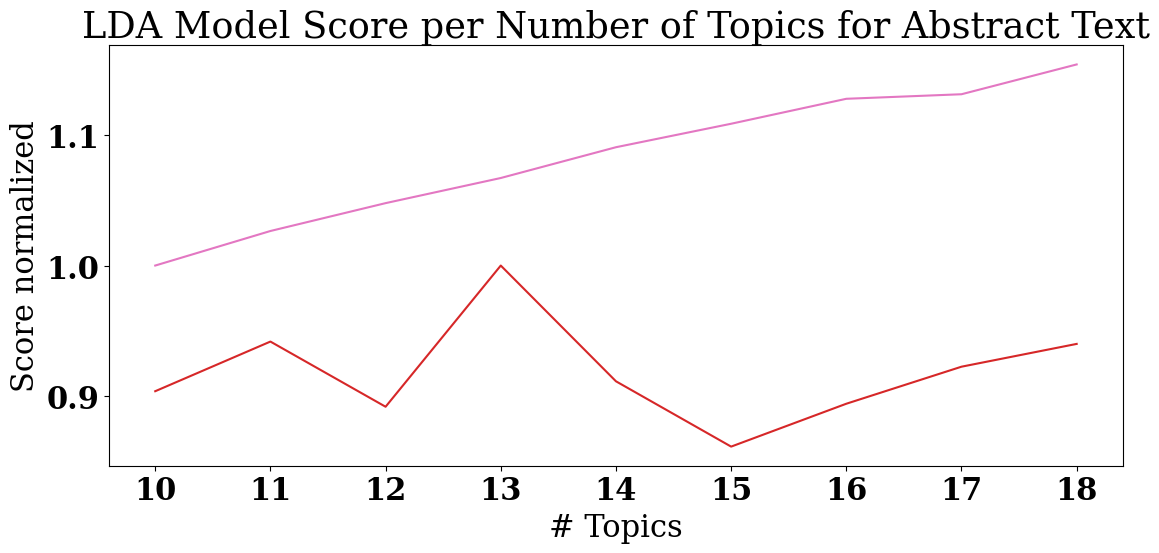

In [357]:
norm_perplexity = [float(i)/max(perplexity) for i in perplexity]
norm_coherence = [float(i)/max(coherence) for i in coherence]

fig, ax = plt.subplots()
plt.plot(topics, norm_perplexity, label='Perplexity')
plt.plot(topics, norm_coherence, label='Coherence')
plt.title('LDA Model Score per Number of Topics for Abstract Text')
plt.xlabel('# Topics')
plt.ylabel('Score normalized')
plt.show()

save_path = f'Plots/{date.today()}/model_score_abstract'
plt.savefig(save_path)

In [359]:
#save topic model with num_topics=15, passes=4, workers=4
with open('Data backup/30112023TopicModel15.pkl', 'wb') as f:
    pickle.dump(lda_model_tfidf, f)

In [360]:
#show topic and its words 
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"flow" + 0.005*"model" + 0.004*"materi" + 0.004*"devic" + 0.004*"temperatur" + 0.004*"simul" + 0.003*"surfac" + 0.003*"fluid" + 0.003*"structur" + 0.003*"pressur"
Topic: 1 Word: 0.010*"star" + 0.008*"galaxi" + 0.007*"observ" + 0.007*"dark" + 0.007*"solar" + 0.006*"gravit" + 0.006*"cosmic" + 0.006*"mass" + 0.006*"cosmolog" + 0.006*"black"
Topic: 2 Word: 0.030*"email" + 0.019*"physh" + 0.019*"societyphys" + 0.018*"american" + 0.016*"publish" + 0.015*"head" + 0.014*"http" + 0.013*"addressth" + 0.013*"providedcopi" + 0.012*"author"
Topic: 3 Word: 0.021*"literaci" + 0.018*"worksheet" + 0.018*"shale" + 0.017*"ultracold" + 0.014*"weld" + 0.012*"ferroelectr" + 0.012*"ran" + 0.011*"inlet" + 0.010*"neutrinoless" + 0.009*"nitrid"
Topic: 4 Word: 0.053*"search" + 0.032*"icon" + 0.027*"orlando" + 0.020*"merger" + 0.019*"citat" + 0.018*"toolbar" + 0.017*"june" + 0.017*"divis" + 0.017*"http" + 0.014*"annual"
Topic: 5 Word: 0.012*"neutrino" + 0.010*"decay" + 0.010*"detector" + 0.00

In [361]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.save_html(vis, f'Plots/{date.today()}/topic_abstract_{num_topics}_topics.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.238056  0.059016       1        1  14.949754
12    -0.190218 -0.063690       2        1  14.396568
0     -0.243899  0.034988       3        1  14.261212
14    -0.236985  0.030556       4        1  12.863520
7     -0.220691  0.032798       5        1   9.238242
5     -0.232668  0.056884       6        1   8.306492
1     -0.215818  0.071009       7        1   6.097289
9      0.089108 -0.208137       8        1   5.054604
6      0.083390 -0.186386       9        1   4.106154
2      0.139132 -0.256232      10        1   2.993421
4      0.202129 -0.135331      11        1   1.909117
8      0.250881  0.114174      12        1   1.554926
13     0.267059  0.174340      13        1   1.552365
3      0.271669  0.150280      14        1   1.433872
11     0.274968  0.125731      15        1   1.282463, topic_info=              Term          Freq         Total Category  logprob  loglift
2007        materi  10312.000000  10312.000000  Default  30.0000  30.0000
19          biolog   6617.000000   6617.000000  Default  29.0000  29.0000
124         search   5962.000000   5962.000000  Default  28.0000  28.0000
5          journal   7232.000000   7232.000000  Default  27.0000  27.0000
2981       student   8095.000000   8095.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
10367  velocimetri    203.765594    226.346026  Topic15  -5.2896   4.2513
8023          flip    366.429110    519.770662  Topic15  -4.7028   4.0068
11709        dimer    248.858153    360.366323  Topic15  -5.0897   3.9861
547        pairwis    221.851933    289.785482  Topic15  -5.2046   4.0893
2268       singlet    300.543375    611.386684  Topic15  -4.9010   3.6463

[1083 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3232       1  0.993169   abelian
742       10  0.990054  aboutpdf
184        1  0.002126    academ
184        2  0.611534    academ
184        3  0.007795    academ
...      ...       ...       ...
3741       9  0.002590     zhang
3741      10  0.062162     zhang
3741      11  0.098423     zhang
25198      4  0.995577      zoom
135       11  0.996820    zotero

[4341 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 13, 1, 15, 8, 6, 2, 10, 7, 3, 5, 9, 14, 4, 12])

In [363]:
#assign topic label based on term frequency and weight 
topics_tfidf=pd.DataFrame(lda_model_tfidf.print_topics())

In [364]:
topics = [
    "Computational Physics and Fluid Dynamics",
    "Astrophysics and Cosmology",
    "Publishing and Physics Societies",
    "Materials Science and Geophysics",
    "Scientific Research and Citation",
    "Particle Physics and Collider Experiments",
    "Materials Science, Biology, and Medicine",
    "Plasma Physics and Atmospheric Science",
    "Mathematics and Robotics",
    "Scholarly Communication and Institutions",
    "Quantum Physics and Topology",
    "Quantum Information and Misconceptions",
    "Education and Research",
    "Machine Learning and Bayesian Methods",
    "Machine Learning and Neural Networks"
]

topics_tfidf['abstract_topic_label'] = topics


In [365]:
topics_tfidf=topics_tfidf.rename(columns={0: "abstract_topic_index", 1: "abstract_topic_words"})
topics_tfidf

,topic_index,topic_words,abstract_topic_label
0,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics
1,1,"0.010*""star"" + 0.008*""galaxi"" + 0.007*""observ""...",Astrophysics and Cosmology
2,2,"0.030*""email"" + 0.019*""physh"" + 0.019*""society...",Publishing and Physics Societies
3,3,"0.021*""literaci"" + 0.018*""worksheet"" + 0.018*""...",Materials Science and Geophysics
4,4,"0.053*""search"" + 0.032*""icon"" + 0.027*""orlando...",Scientific Research and Citation
5,5,"0.012*""neutrino"" + 0.010*""decay"" + 0.010*""dete...",Particle Physics and Collider Experiments
6,6,"0.046*""materi"" + 0.042*""journal"" + 0.041*""biol...","Materials Science, Biology, and Medicine"
7,7,"0.008*""plasma"" + 0.006*""laser"" + 0.004*""puls"" ...",Plasma Physics and Atmospheric Science
8,8,"0.065*""math"" + 0.051*""xmln"" + 0.042*""robot"" + ...",Mathematics and Robotics
9,9,"0.013*""scholar"" + 0.012*""googl"" + 0.009*""unive...",Scholarly Communication and Institutions


In [385]:
#let's assing topic label to each article and topic probability 
max_scores = {}  # Create an empty dictionary to store max scores and indices

for doc_index, doc in enumerate(corpus_tfidf):
    max_score = None
    max_index = None

    for index, score in sorted(lda_model_tfidf[doc], key=lambda tup: -1 * tup[1]):
        if max_score is None or score > max_score:
            max_score = score
            max_index = index

    # Store both the max score and its index in the dictionary
    max_scores[doc_index] = {'abstract_topic_max_score': max_score, 'abstract_topic_index': max_index}

In [386]:
max_scores=pd.DataFrame(max_scores).T

In [387]:
max_scores

,topic_max_score,topic_index
0,0.400144,12.0
1,0.731486,10.0
2,0.715223,10.0
3,0.638965,1.0
4,0.865740,4.0
...,...,...
518346,0.578227,14.0
518347,0.804606,10.0
518348,0.678734,0.0
518349,0.866105,12.0


In [ ]:
#HERTIL!!!!: 

In [ ]:
#evt gem abstract text også fra corpus_tfidf så vi lettere kan tjekke at vi merger rigtigt med abstract topic 

In [400]:
text_data_test=text_data.join(max_scores)
text_data_test

,article_id,title,abstract,topic_max_score,topic_index
0,https://openalex.org/W2149166552,Electrical resistance of disordered one-dimens...,(1970). Electrical resistance of disordered on...,0.400144,12.0
1,https://openalex.org/W2048737175,Oscillatory approach to a singular point in th...,(1970). Oscillatory approach to a singular poi...,0.731486,10.0
4,https://openalex.org/W2062259223,Solutions of ordinary differential equations a...,"In a great variety of fields, e.g., biology, e...",0.865740,4.0
5,https://openalex.org/W3187596537,Physics of shock waves and high-temperature hy...,Physics of Shock Waves and High-Temperature Hy...,0.863383,10.0
7,https://openalex.org/W2079552349,Critical Density in Percolation Processes,Views Icon Views Article contents Figures & ta...,0.723308,2.0
...,...,...,...,...,...
2000270,https://openalex.org/W4385871799,Computational Physics of Insect Flight — Aeria...,The aerodynamics of insect flight is a subject...,NaN,NaN
2000271,https://openalex.org/W4386270869,Deciphering Long-Range Order in Active Matter:...,Emergent order resulting from spontaneous symm...,NaN,NaN
2000272,https://openalex.org/W4387932510,Cellular Ethological Dynamics in Diorama Envir...,How smart can cells behave under complicated e...,NaN,NaN
2000276,https://openalex.org/W4363652123,İleriye Yönelik ve Geriye Dönük Zamanlama Süre...,We experience a flow of time in everyday life....,NaN,NaN


In [398]:
len(text_data)

518351

In [399]:
len(text_data_test)

518351

In [ ]:
max_scores['article_index']=max_scores.index

In [ ]:
max_scores

In [378]:
topics_tfidf.head(3)

,topic_index,topic_words,abstract_topic_label
0,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics
1,1,"0.010*""star"" + 0.008*""galaxi"" + 0.007*""observ""...",Astrophysics and Cosmology
2,2,"0.030*""email"" + 0.019*""physh"" + 0.019*""society...",Publishing and Physics Societies


In [379]:
max_scores.head(3)

,topic_max_score,topic_index
0,0.401707,12.0
1,0.731486,10.0
2,0.714397,10.0


In [382]:
len(max_scores)

518351

In [381]:
#merge the topic label dataframe and the topic score dataframe
topics_tfidf_max_scores=pd.merge(topics_tfidf, max_scores, on='topic_index')

In [383]:
len(topics_tfidf_max_scores)

518351

In [384]:
topics_tfidf_max_scores

,topic_index,topic_words,abstract_topic_label,topic_max_score
0,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics,0.795690
1,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics,0.751849
2,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics,0.646001
3,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics,0.848795
4,0,"0.005*""flow"" + 0.005*""model"" + 0.004*""materi"" ...",Computational Physics and Fluid Dynamics,0.642976
...,...,...,...,...
518346,14,"0.008*""network"" + 0.007*""model"" + 0.007*""data""...",Machine Learning and Neural Networks,0.607893
518347,14,"0.008*""network"" + 0.007*""model"" + 0.007*""data""...",Machine Learning and Neural Networks,0.603038
518348,14,"0.008*""network"" + 0.007*""model"" + 0.007*""data""...",Machine Learning and Neural Networks,0.777824
518349,14,"0.008*""network"" + 0.007*""model"" + 0.007*""data""...",Machine Learning and Neural Networks,0.577890


In [ ]:
#MERGE WITH OVERALL DATA: first_author_article_data.head(2)

In [ ]:
topics_tfidf_max_scores.index=[topics_tfidf_max_scores['article_index']]

In [ ]:
topics_tfidf_max_scores = topics_tfidf_max_scores.rename_axis(None, axis=0)

In [ ]:
topics_tfidf_max_scores = topics_tfidf_max_scores.rename(lambda x: int(x.split("_")[1]))
topics_tfidf_max_scores = topics_tfidf_max_scores.sort_index()

In [ ]:
topics_tfidf_max_scores.index=[f'article_{i}' for i in range(len(article_iter))]

In [ ]:
topics_tfidf_max_scores

#### Title 

In [1548]:
#define the text data we want to analyse as documents 
documents=text_title

In [1549]:
doc_sample = documents[documents['index'] == 4310].values[0][1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Exact', 'Solutions', 'to', 'the', 'Coupled', 'Hartree-Fock', 'Perturbation', 'Equations']


 tokenized and lemmatized document: 
['exact', 'solut', 'coupl', 'hartre', 'fock', 'perturb', 'equat']


In [1550]:
#preprocess the abstract text, saving the results as ‘processed_docs’
processed_docs = documents['title'].dropna().map(preprocess)
processed_docs[:10]

0          [electr, resist, disord, dimension, lattic]
1    [oscillatori, approach, singular, point, relat...
2    [solut, ordinari, differenti, equat, limit, pu...
3    [physic, shock, wave, high, temperatur, hydrod...
4                   [critic, densiti, percol, process]
5              [distribut, wave, equat, finit, domain]
6       [prescrib, random, variabl, condit, distribut]
7    [photochem, reaction, amino, acid, residu, ina...
8                                     [euler, potenti]
9    [multi, compon, radiat, surviv, curv, vitro, t...
Name: title, dtype: object

In [1519]:
#create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 dimension
1 disord
2 electr
3 lattic
4 resist
5 approach
6 cosmolog
7 oscillatori
8 point
9 relativist
10 singular


In [1520]:
#Filter out tokens that appear in less than 15 documents (absolute number) or 
#more than 0.5 documents (fraction of total corpus size, not absolute number).
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [1523]:
len(dictionary)

10239

In [1521]:
#For each document we create a dictionary reporting how many words and how many times those words appear. 
#Save this to ‘bow_corpus’, then check our selected sample document earlier.

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(23, 1), (1498, 1), (2858, 1)]

In [1522]:
#Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
#then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.36866860637853827),
 (1, 0.5286617984027412),
 (2, 0.4005949047352723),
 (3, 0.4193884209725788),
 (4, 0.4982341178951427)]


In [1544]:
#Define model parameters
num_topics=16
passes=1
workers=4
random_seed=24

In [1545]:
%%time

#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, random_state=random_seed, passes=passes, workers=workers)


CPU times: user 21.1 s, sys: 29.6 s, total: 50.7 s
Wall time: 6min 47s


In [1557]:
#print number of topics for the score
print('topics:', num_topics)

# Compute Perplexity
print('\n TFIDF Perplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n TFIDF Coherence Score: ', coherence_lda)
#a measure of how interpretable the model is. Higher the better. 

topics: 16

 TFIDF Perplexity:  -11.584991229897877

 TFIDF Coherence Score:  0.37368919091253716


In [1558]:
#show topic and words 
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.021*"circuit" + 0.020*"prospect" + 0.018*"anomali" + 0.017*"manufactur" + 0.017*"augment" + 0.016*"twin" + 0.016*"manipul" + 0.015*"atla" + 0.012*"systemat" + 0.011*"white"
Topic: 1 Word: 0.039*"machin" + 0.032*"learn" + 0.020*"framework" + 0.017*"msub" + 0.013*"cosmic" + 0.012*"higher" + 0.011*"recent" + 0.010*"physic" + 0.009*"assess" + 0.009*"qualiti"
Topic: 2 Word: 0.026*"matter" + 0.026*"dark" + 0.013*"entangl" + 0.012*"star" + 0.012*"gravit" + 0.011*"probe" + 0.010*"chiral" + 0.010*"soliton" + 0.009*"wave" + 0.009*"light"
Topic: 3 Word: 0.020*"hole" + 0.019*"black" + 0.010*"reduc" + 0.010*"addit" + 0.009*"fisika" + 0.009*"model" + 0.008*"entropi" + 0.008*"tempor" + 0.007*"tunabl" + 0.007*"revisit"
Topic: 4 Word: 0.025*"equat" + 0.021*"quantum" + 0.014*"theori" + 0.014*"differenti" + 0.013*"solut" + 0.011*"solv" + 0.011*"problem" + 0.011*"fraction" + 0.011*"nonlinear" + 0.010*"physic"
Topic: 5 Word: 0.033*"physic" + 0.030*"student" + 0.028*"learn" + 0.022*"scienc"

In [1559]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
#pyLDAvis.save_html(vis, 'Plots/22102023/topic_model_tfidf.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.248720  0.026851       1        1  8.407800
9      0.115085 -0.097222       2        1  7.897114
4      0.029647 -0.095599       3        1  7.471082
13     0.115964 -0.090036       4        1  7.029568
2      0.159898  0.036438       5        1  6.762333
14     0.033391 -0.083850       6        1  6.386855
8     -0.027242 -0.098553       7        1  6.005567
3      0.079198 -0.087654       8        1  5.993049
11     0.053312  0.274336       9        1  5.905001
10    -0.084308 -0.075387      10        1  5.894164
1     -0.162305 -0.006841      11        1  5.884425
15     0.166513  0.011820      12        1  5.773437
12    -0.062054 -0.047062      13        1  5.640269
7     -0.100455  0.015159      14        1  5.286654
6      0.131500  0.212294      15        1  5.080106
0     -0.199424  0.105306      16        1  4.582577, topic_info=         Term         Freq         Total Category  logprob  loglift
1676   neural  4499.000000   4499.000000  Default  30.0000  30.0000
2027     math  3646.000000   3646.000000  Default  29.0000  29.0000
1403  network  5278.000000   5278.000000  Default  28.0000  28.0000
879    machin  4280.000000   4280.000000  Default  27.0000  27.0000
456     learn  9464.000000   9464.000000  Default  26.0000  26.0000
...       ...          ...           ...      ...      ...      ...
2079   inject   372.273109    517.754582  Topic16  -5.0159   2.7530
1185    digit   490.001932   1597.906315  Topic16  -4.7411   1.9009
1104     work   392.697493    788.919010  Topic16  -4.9625   2.3853
23     physic   548.210371  11791.593691  Topic16  -4.6289   0.0144
456     learn   400.229257   9464.024129  Topic16  -4.9435  -0.0803

[916 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4366     11  0.995690  abelian
4030     11  0.998257     abil
2110      5  0.995975   absorb
1504      1  0.997205   academ
927       4  0.997580   access
...     ...       ...      ...
2029     15  0.999057     xmln
593       1  0.940075     year
593      14  0.023641     year
593      16  0.034766     year
614       7  0.995004    yield

[2680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 5, 14, 3, 15, 9, 4, 12, 11, 2, 16, 13, 8, 7, 1])

### Topic classification

In [1554]:
#start by splitting data into data for manual labelling 
# Select 10% of the data randomly
label_sample = text_data.sample(frac=0.1)
print(len(label_sample))

51835


In [1555]:
#save text data for labelling
label_sample.to_csv('text_data_label.csv')  


In [1556]:
label_sample.head(10)

,article_id,title,abstract
362489,https://openalex.org/W2130687817,On inflation and torsion in cosmology,"AbstractIn a recent letter by H. Davoudiasl, R..."
245511,https://openalex.org/W2376666933,An Application of Brovey Image Fusion in Land ...,Image fusion is one of widely used techniques ...
248103,https://openalex.org/W2992678570,Assessment of Prerequisite Classes,We present an assessment tool for the impact o...
1002156,https://openalex.org/W2258687439,Interfacial Phenomena and Fluid Control in Mic...,Fundamental aspects of rapidly advancing micro...
669308,https://openalex.org/W2385420470,Effects of Rice Straw Backed to Soil in Double...,Rice straw recycled back to the soil was done ...
225770,https://openalex.org/W225371012,Presentation of the Database,Abstract : With the continuous progress in har...
1976556,https://openalex.org/W4387494264,Development of a tectonic earthquake knowledge...,Abstract In order to enhance students’ critica...
1423335,https://openalex.org/W3088668111,Thermodynamics at Very Long Time and Space Scales,"Any observation, and hence concept, is limited..."
81952,https://openalex.org/W2061824002,Fixed-Target Hadroproduction of Beauty: In Fer...,Various experimental approaches to obtaining l...
1207751,https://openalex.org/W2798880851,Complex saddle trajectories for multidimension...,A practical search technique for finding the c...
